In [1]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy.stats import rankdata

# 1. preprocess

In [2]:
subjs, subjs_data = [202512, 202511, 202509, 'tori', 'amisha', 'erfan'], []
# subjs, subjs_data = [202512, 202511, 202509], []
for subj in subjs:
    df_subj = pd.read_csv(glob.glob(f'../../results/psychopy/*{subj}*csv')[0])[:-1]
    subjs_data.append(df_subj)

df_subjs = pd.concat(subjs_data, ignore_index=True)
assert len(df_subjs) == 0 or df_subjs['subj'].nunique() == len(subjs), "#rows != #subjs * #trials"
print(df_subjs.columns.tolist())
df_subjs

['thisN', 'thisTrialN', 'thisRepN', 'blockN', 'run', 'condition', 'trial_key', 'stim_file_pos', 'stim_pos', 'noise_pos', 'marker_init', 'shape', 'shape_order', 'div_pos', 'target_pos', 'subj_C0F1_val', 'subj_C1F0_val', 'target_file', 'img1_file', 'img2_file', 'block_start_resp.keys', 'block_start_resp.rt', 'block_start_resp.duration', 'marker.response', 'marker.rt', 'slider_resp.keys', 'slider_resp.rt', 'slider_resp.duration', 'submit_resp.keys', 'submit_resp.rt', 'submit_resp.duration', 'blocks.thisRepN', 'blocks.thisTrialN', 'blocks.thisN', 'blocks.thisIndex', 'trials.thisRepN', 'trials.thisTrialN', 'trials.thisN', 'trials.thisIndex', 'thisRow.t', 'notes', 'block_start.started', 'block_start_text.started', 'block_start_resp.started', 'block_start.stopped', 'blocks.block_start_resp.keys', 'blocks.block_start_resp.rt', 'blocks.block_start_resp.duration', 'baseline.started', 'ISI1.started', 'baseline.stopped', 'stim.started', 'target_stim.started', 'target_stim.stopped', 'stim.stopped',

,thisN,thisTrialN,thisRepN,blockN,run,condition,trial_key,stim_file_pos,stim_pos,noise_pos,...,Mcoin.started,Mcoin.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122
0,0.0,0.0,0.0,1.0,1.0,baseline,21.0,2.1,0.02,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.0,1.0,1.0,baseline,35.0,3.5,0.30,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.0,0.0,1.0,1.0,baseline,26.0,2.7,0.14,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3.0,0.0,1.0,1.0,baseline,5.0,0.5,-0.30,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4.0,0.0,1.0,1.0,baseline,37.0,3.7,0.34,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,35.0,35.0,0.0,6.0,2.0,flat_comp,210.0,2.1,0.02,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1436,36.0,36.0,0.0,6.0,2.0,flat_comp,212.0,2.3,0.06,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1437,37.0,37.0,0.0,6.0,2.0,flat_comp,218.0,2.9,0.18,4.0,...,2112.874905,2113.875868,NaN,NaN,NaN,NaN,2112.874905,2113.875868,NaN,NaN
1438,38.0,38.0,0.0,6.0,2.0,flat_comp,238.0,3.9,0.38,0.0,...,2119.716484,2120.717329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_subjs = pd.DataFrame()

# init new cols
for col in ['dir_flip', 'sess_flip',
            'chosen_pos_aligned', 'div_pos_aligned', 'stim_pos_aligned',
            'class_true', 'class_pred', 'err_type',
            'signed_err', 'unsigned_err', 'dist_moved', 'normed_RT', 'difficulty']:
    df_subjs[col] = np.nan

for subj in subjs:

    df_subj = pd.read_csv(glob.glob(f'../../results/psychopy/*{subj}*')[0])[:240]

    df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)
    assert df_subj['trial_key'].is_monotonic_increasing, 'trial_key is not sorted correctly'

    df_subj['class_true'] = np.where( df_subj['valence'] == 'rew', 1, 0 )
    assert df_subj['class_true'].sum() == len(df_subj)/2, 'class_true is imbalanced'

    # convert str to list, and store chosen position
    for col in ['positions']:
        if type(df_subj[col][0]) == str:
            df_subj.loc[:, col] = df_subj[col].apply(ast.literal_eval)
            
    df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
    
## must sequentially align for flips & sessions because of the double flip situations

# 1. aligning for direction flips
    df_subj['dir_flip'] = (df_subj['shape_order'] == 'flat_curv').astype(int)
    assert df_subj['dir_flip'].sum() == len(df_subj)/2
   
   # align positions to curv=left, flat=right
    for col_prefix in ['chosen_pos', 'div_pos']: # dont need to unflip stim_pos because target_pos actually gets flipped
        df_subj[col_prefix + '_aligned'] = np.where( df_subj['dir_flip'],
                                                     -df_subj[col_prefix], df_subj[col_prefix] )

# 2. aligning for session type (stim-val association)
    if df_subj['sess_type'][0] in ['A', 'C']: # adam, tori       
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'pen_comp', 'flat_comp':'rew_comp'})
        df_subj['sess_flip'] = 0
        df_subj['stim_pos_aligned'] = df_subj['stim_pos']

    elif df_subj['sess_type'][0] in ['B', 'D']: # amisha, erfan     
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'rew_comp', 'flat_comp':'pen_comp'})
        df_subj['sess_flip'] = 1
        df_subj['stim_pos_aligned'] = -df_subj['stim_pos']

        # align positions to penalty=left, reward=right
        for col in ['chosen_pos_aligned', 'div_pos_aligned']:
            df_subj[col] = -df_subj[col]

    df_subj['class_pred'] = (df_subj['chosen_pos_aligned'] > df_subj['div_pos_aligned']).astype(int)
    df_subj['err_type'] = df_subj['class_pred'] - df_subj['class_true']

    df_subjs = pd.concat([df_subjs, df_subj], ignore_index=True)

# accounting for older versions where large outcome was +-2
df_subjs['outcome'] = df_subjs['outcome'].replace({2: 3, -2: -3})

df_subjs = df_subjs.copy()

# invalid, missed, purely_incorrect trials
df_subjs['invalid'] = df_subjs['trials.slider_resp.rt'].isna()
df_subjs['missed'] = df_subjs['trials.submit_resp.keys'].isna()
df_subjs['purely_incorrect'] = (df_subjs['correct']==0) & ~df_subjs['trials.slider_resp.rt'].isna() & ~df_subjs['trials.submit_resp.keys'].isna()

# calculate pred-true
df_subjs['signed_err'] = df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']
df_subjs['unsigned_err'] = (df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']).abs()

# RT normed by distance moved
df_subjs['dist_moved'] = (df_subjs['chosen_pos'] - df_subjs['marker_init']).abs()
df_subjs['normed_RT'] = df_subjs['trials.submit_resp.rt']/ (10 * (df_subjs['dist_moved'] + .01) )

# binary value of difficulty
df_subjs['difficulty'] = (df_subjs['target_pos'] - df_subjs['div_pos']).abs() < 0.1

# rank within a block for each subj/cond
grp = ['subj', 'condition', 'blockN']
# build both ranks, assign once, then copy to defragment
df_subjs = df_subjs.assign(
    stim_ranks = df_subjs.groupby(grp)['stim_pos_aligned'].transform('rank'),
    resp_ranks = df_subjs.groupby(grp)['chosen_pos_aligned'].transform('rank'),
).copy()
max_rank = df_subjs['stim_ranks'].max()

# rename subjs
subj_rename = {202512.0: '12', 202511.0: '11', 202509.0: '09', 'tori': 'T', 'amisha': 'A', 'erfan': 'E'}
df_subjs['subj'] = df_subjs['subj'].replace(subj_rename)

df_subjs = df_subjs.copy()

# asserts

df_subjs.to_csv('../../results/psychopy/all_subjs_clean.csv', index=False)

print(df_subjs['outcome'].value_counts(), '\n')
print(df_subjs['correct'].value_counts(), '\n')
print(df_subjs.shape, '\n')
assert len(df_subjs) == 240 * len(subjs), "Total trials do not match expected number"

disp_cols = ['sess_type', 'sess_flip', 'shape_order', 'dir_flip', 'target_pos', 'shape', 'valence', 'class_true',
             'div_pos', 'div_pos_aligned', 'stim_pos', 'stim_pos_aligned', 'chosen_pos', 'chosen_pos_aligned', 'class_pred', 'err_type',
             'signed_err', 'unsigned_err']

df_subjs[(df_subjs['sess_type'] == 'B') &
         (df_subjs['condition'] == 'baseline') &
         (df_subjs['err_type'] != 0) &
         (df_subjs['sess_flip'] != df_subjs['dir_flip'])
        ][disp_cols][:20]


outcome
 1.0    580
 3.0    565
-1.0    142
-3.0    126
 0.0     27
Name: count, dtype: int64 

correct
1.0    1145
0.0     295
Name: count, dtype: int64 

(1440, 153) 



,sess_type,sess_flip,shape_order,dir_flip,target_pos,shape,valence,class_true,div_pos,div_pos_aligned,stim_pos,stim_pos_aligned,chosen_pos,chosen_pos_aligned,class_pred,err_type,signed_err,unsigned_err
244,B,1.0,curv_flat,0.0,-0.30,curv,rew,1.0,0.0,-0.0,-0.30,0.30,0.040,-0.040,0.0,-1.0,-0.340,0.340
250,B,1.0,curv_flat,0.0,-0.18,curv,rew,1.0,0.0,-0.0,-0.18,0.18,0.016,-0.016,0.0,-1.0,-0.196,0.196
254,B,1.0,curv_flat,0.0,-0.10,curv,rew,1.0,0.0,-0.0,-0.10,0.10,0.024,-0.024,0.0,-1.0,-0.124,0.124
258,B,1.0,curv_flat,0.0,-0.02,curv,rew,1.0,0.0,-0.0,-0.02,0.02,0.068,-0.068,0.0,-1.0,-0.088,0.088
260,B,1.0,curv_flat,0.0,0.02,flat,pen,0.0,0.0,-0.0,0.02,-0.02,-0.220,0.220,1.0,1.0,0.240,0.240
364,B,1.0,curv_flat,0.0,-0.30,curv,rew,1.0,0.0,-0.0,-0.30,0.30,0.016,-0.016,0.0,-1.0,-0.316,0.316
366,B,1.0,curv_flat,0.0,-0.26,curv,rew,1.0,0.0,-0.0,-0.26,0.26,0.040,-0.040,0.0,-1.0,-0.300,0.300
372,B,1.0,curv_flat,0.0,-0.14,curv,rew,1.0,0.0,-0.0,-0.14,0.14,0.012,-0.012,0.0,-1.0,-0.152,0.152
374,B,1.0,curv_flat,0.0,-0.10,curv,rew,1.0,0.0,-0.0,-0.10,0.10,0.012,-0.012,0.0,-1.0,-0.112,0.112
378,B,1.0,curv_flat,0.0,-0.02,curv,rew,1.0,0.0,-0.0,-0.02,0.02,0.048,-0.048,0.0,-1.0,-0.068,0.068


# 2. read df

In [4]:
df_subjs = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')

subjs = ['09', '11', 'A', '12', 'E', 'T']
conds = ['pen_comp', 'baseline', 'rew_comp']
df_subjs['invalid']
# non missing/invalid trials
df_clean = df_subjs[~df_subjs['invalid'] & ~df_subjs['missed']].copy()
print(len(df_subjs), len(df_clean))

df_clean

1440 1382


,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,signed_err,unsigned_err,...,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122,invalid,missed,purely_incorrect,stim_ranks,resp_ranks
0,0.0,0.0,-0.400,0.0,-0.38,0.0,0.0,0.0,-0.020,0.020,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,1.5
1,1.0,0.0,-0.148,-0.0,-0.38,0.0,0.0,0.0,0.232,0.232,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,20.0
2,0.0,0.0,-0.308,0.0,-0.34,0.0,0.0,0.0,0.032,0.032,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,7.0
3,1.0,0.0,-0.304,-0.0,-0.34,0.0,0.0,0.0,0.036,0.036,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,8.0
4,0.0,0.0,-0.328,0.0,-0.30,0.0,0.0,0.0,-0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,False,False,False,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1.0,1.0,-0.248,-0.2,-0.34,0.0,0.0,0.0,0.092,0.092,...,NaN,NaN,NaN,NaN,NaN,False,False,False,6.5,15.0
1436,0.0,1.0,-0.252,-0.2,-0.38,0.0,0.0,0.0,0.128,0.128,...,NaN,NaN,NaN,NaN,NaN,False,False,False,2.5,13.0
1437,1.0,1.0,-0.228,-0.2,-0.38,0.0,0.0,0.0,0.152,0.152,...,NaN,NaN,NaN,NaN,NaN,False,False,False,2.5,27.5
1438,0.0,1.0,-0.244,-0.2,-0.38,0.0,0.0,0.0,0.136,0.136,...,NaN,NaN,NaN,NaN,NaN,False,False,False,2.5,18.5


In [5]:
# choose whether plotting for subj or pop
def get_df(df, subj_or_pop):
    return subj_or_pop, df.copy() if subj_or_pop == 'pop' else df[df['subj'] == subj_or_pop].copy()

# test
subj_or_pop, df_analysis = get_df(df_clean, 'pop')
print(f'\nplotting for subj-{subj_or_pop}\nlen(df) = {len(df_analysis)}')
df_analysis


plotting for subj-pop
len(df) = 1382


,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,class_true,class_pred,err_type,signed_err,unsigned_err,...,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122,invalid,missed,purely_incorrect,stim_ranks,resp_ranks
0,0.0,0.0,-0.400,0.0,-0.38,0.0,0.0,0.0,-0.020,0.020,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,1.5
1,1.0,0.0,-0.148,-0.0,-0.38,0.0,0.0,0.0,0.232,0.232,...,NaN,NaN,NaN,NaN,NaN,False,False,False,1.5,20.0
2,0.0,0.0,-0.308,0.0,-0.34,0.0,0.0,0.0,0.032,0.032,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,7.0
3,1.0,0.0,-0.304,-0.0,-0.34,0.0,0.0,0.0,0.036,0.036,...,NaN,NaN,NaN,NaN,NaN,False,False,False,3.5,8.0
4,0.0,0.0,-0.328,0.0,-0.30,0.0,0.0,0.0,-0.028,0.028,...,NaN,NaN,NaN,NaN,NaN,False,False,False,5.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,1.0,1.0,-0.248,-0.2,-0.34,0.0,0.0,0.0,0.092,0.092,...,NaN,NaN,NaN,NaN,NaN,False,False,False,6.5,15.0
1436,0.0,1.0,-0.252,-0.2,-0.38,0.0,0.0,0.0,0.128,0.128,...,NaN,NaN,NaN,NaN,NaN,False,False,False,2.5,13.0
1437,1.0,1.0,-0.228,-0.2,-0.38,0.0,0.0,0.0,0.152,0.152,...,NaN,NaN,NaN,NaN,NaN,False,False,False,2.5,27.5
1438,0.0,1.0,-0.244,-0.2,-0.38,0.0,0.0,0.0,0.136,0.136,...,NaN,NaN,NaN,NaN,NaN,False,False,False,2.5,18.5


# 3. checks

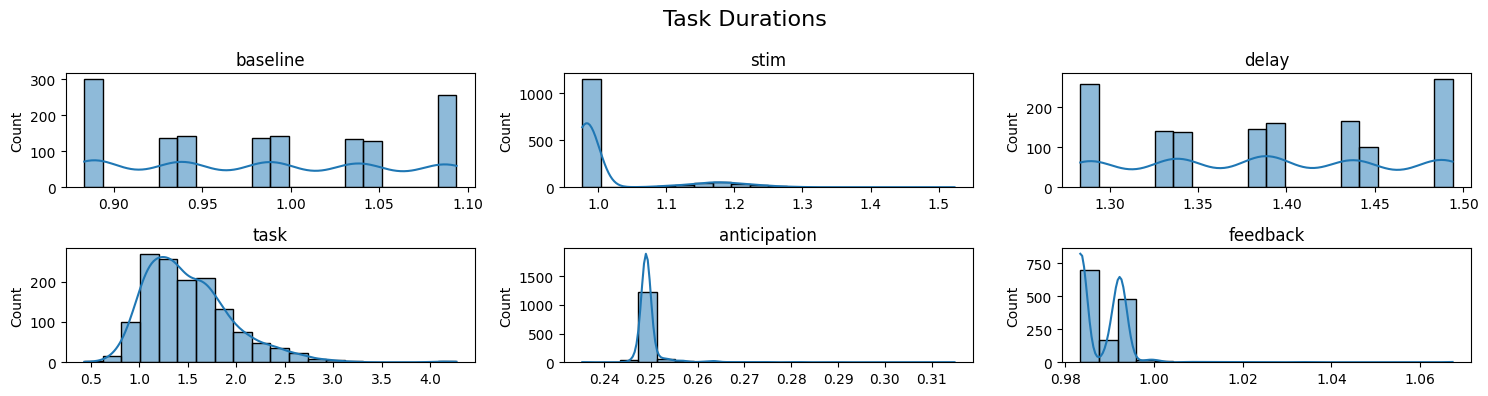

In [6]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# create column for each phases's duration
expt_phases = ['baseline', 'stim', 'delay', 'task', 'anticipation', 'feedback']
for phase in expt_phases:
    df_analysis[f'{phase}_dur'] = df_analysis[f'{phase}.stopped'] - df_analysis[f'{phase}.started']

# sid, check if these are needed replacements
df_analysis['stim_dur'] = df_analysis['stim.stopped'] - df_analysis['target_stim.started']
df_analysis['feedback_dur'] = df_analysis['feedback.stopped'] - df_analysis['no_resp_text.started']

fig, axs = plt.subplots(2, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0

for expt_phase in expt_phases:

    sns.histplot(df_analysis[f'{expt_phase}_dur'], bins=20, kde=True, ax=axs[ax])
    axs[ax].set(title=expt_phase, xlabel='', ylabel='Count')
    ax += 1

plt.suptitle(f'Task Durations', fontsize=16)
plt.tight_layout()
plt.show()

# print which trials with feedback duration < .99
# short_feedback = df_analysis.loc[df_analysis['feedback_dur'] < 0.998]
# print(f'{len(short_feedback)} trials: {short_feedback.index.tolist()}')

In [7]:
subj_or_pop, df_analysis = get_df(df_subjs, 'pop')

num_missed = df_analysis['missed'].sum()
num_invalid = df_analysis['invalid'].sum()
num_purely_incorrect = df_analysis['purely_incorrect'].sum()
print(f'patient: {subj_or_pop}')
print(f'\
missed: {num_missed} ({num_missed / 240 * 100:.2f}%),\
 invalid: {num_invalid} ({num_invalid / 240 * 100:.2f}%),\
 incorrect: {num_purely_incorrect} ({num_purely_incorrect / 240 * 100:.2f}%)')

# proportion correct
prop_correct = df_analysis['correct'].mean()
print(f'Proportion correct: {prop_correct:.2f}')

# pearson and spearman correlations between stim_pos_aligned and chosen_pos_aligned
pearson_corr = df_analysis['stim_pos_aligned'].corr(df_analysis['chosen_pos_aligned'], method='pearson')
spearman_corr = df_analysis['stim_pos_aligned'].corr(df_analysis['chosen_pos_aligned'], method='spearman')
print(f'Pearson correlation: {pearson_corr:.2f}')
print(f'Spearman correlation: {spearman_corr:.2f}')

# ensure this is the same
pearson_corr = df_analysis['target_pos'].corr(df_analysis['chosen_pos'], method='pearson')
spearman_corr = df_analysis['target_pos'].corr(df_analysis['chosen_pos'], method='spearman')
print(f'Pearson correlation (target_pos vs chosen_pos): {pearson_corr:.2f}')
print(f'Spearman correlation (target_pos vs chosen_pos): {spearman_corr:.2f}')


patient: pop
missed: 15 (6.25%), invalid: 46 (19.17%), incorrect: 237 (98.75%)
Proportion correct: 0.80
Pearson correlation: 0.74
Spearman correlation: 0.74
Pearson correlation (target_pos vs chosen_pos): 0.74
Spearman correlation (target_pos vs chosen_pos): 0.74


## strategies

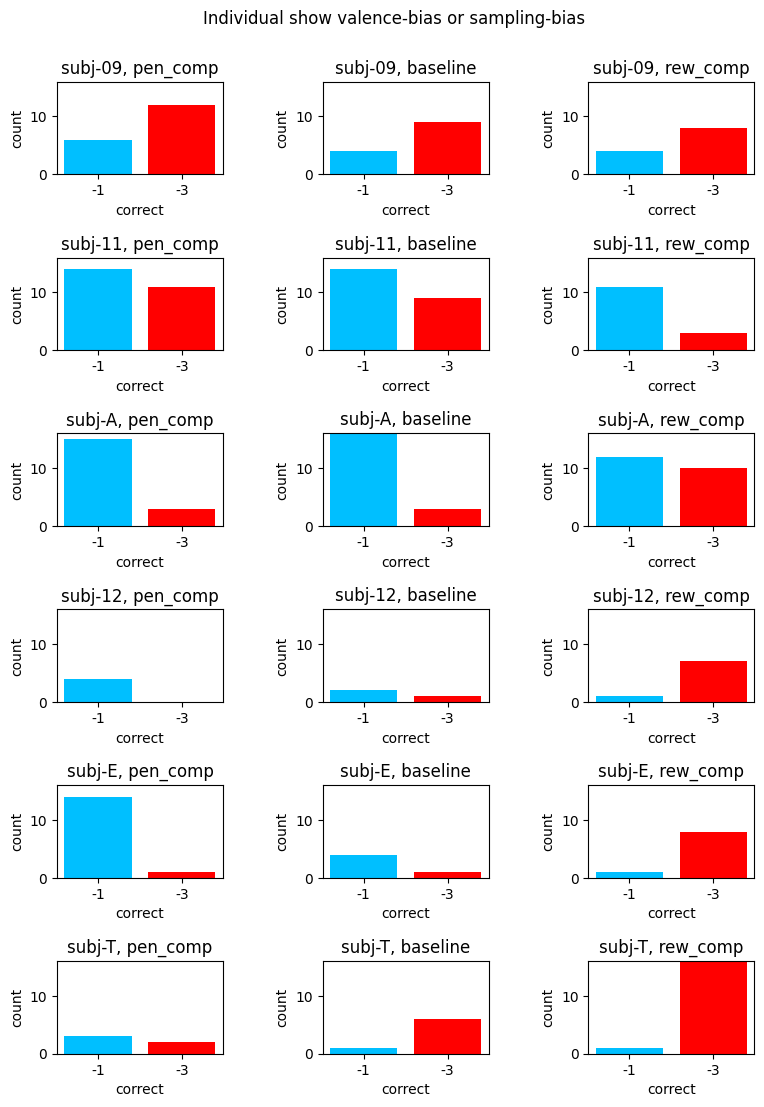

In [8]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

fig, axs = plt.subplots(len(subjs), len(conds), figsize=(3*len(conds), 2*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        # enforce order: -1 then -3
        counts = subj_cond_df['outcome'].value_counts().reindex([-1, -3], fill_value=0)

        # plot at categorical positions [0,1] instead of [-1,-3]
        axs[ax].bar([0, 1], counts.values, color=['deepskyblue', 'red'])

        # manually set ticks/labels in desired order
        axs[ax].set(title=f'subj-{subj}, {cond}', xticks=[0, 1], xticklabels=['-1', '-3'], xlabel='correct', ylim=(0, 16), ylabel='count')

        ax += 1

plt.suptitle('Individual show valence-bias or sampling-bias')
fig.subplots_adjust(wspace=.6, hspace=.9, top=.92)
plt.show()


### where do the errs come from?

In [9]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# df_incorr = df_analysis[df_analysis['purely_incorrect'] == 1]

# fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_incorr[(df_incorr['subj'] == subj) & (df_incorr['condition'] == cond)].copy()

#         # diagonal for perfect accuracy
#         axs[ax].plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)

#         # divider
#         div_pos = subj_cond_df['div_pos_aligned'].iloc[0]
#         axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
#         axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)
        
#         # set
#         axs[ax].set(xlabel='pen   <--stim-->   rew', 
#                     ylabel='safe    <--resp-->   risk',
#                     xlim=(-.4, .4), ylim=(-.4, .4), title=f'subj-{subj}, {cond}')
        
#         # plot points
#         for acc, acc_df in subj_cond_df.groupby('correct'):        
#             axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'], color='red')

#         ax += 1

# plt.suptitle('Stimulus vs Response, error trials', fontsize=16)
# fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
# plt.show()


### TP vs TN

In [10]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# df_corr = df_analysis[df_analysis['correct'] == 1]

# fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_corr[(df_corr['subj'] == subj) & (df_corr['condition'] == cond)].copy()

#         # diagonal for perfect accuracy
#         axs[ax].plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)

#         # divider
#         div_pos = subj_cond_df['div_pos_aligned'].iloc[0]
#         axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
#         axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)
        
#         # set
#         axs[ax].set(xlabel='pen   <--stim-->   rew', 
#                     ylabel='safe    <--resp-->   risk',
#                     xlim=(-.4, .4), ylim=(-.4, .4), title=f'subj-{subj}, {cond}')
        
#         # PLOT
#         # points
#         for acc, acc_df in subj_cond_df.groupby('correct'):        
#             axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'], color='red')

#         ax += 1

# plt.suptitle('Stimulus vs Response, error trials', fontsize=16)
# fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
# plt.show()


## avg RT by correct

In [11]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(len(subjs), len(conds), figsize=(3*len(conds), 2*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_incorr[(df_incorr['subj'] == subj) & (df_incorr['condition'] == cond)].copy()

#         # mean normed_RT by outcome (-1 then -3)
#         means = (
#             subj_cond_df
#             .groupby('outcome')['normed_RT']
#             .mean()
#             .reindex([-1, -3])              # enforce order
#         )

#         # OPTIONAL: SEM error bars
#         sems = (
#             subj_cond_df
#             .groupby('outcome')['normed_RT']
#             .apply(lambda x: x.std(ddof=1) / max(len(x)**0.5, 1))
#             .reindex([-1, -3])
#         )

#         # plot at categorical positions [0,1]
#         axs[ax].bar([0, 1], means.values, yerr=sems.values, capsize=3, color=['deepskyblue', 'red'])

#         axs[ax].set(
#             title=f'subj-{subj}, {cond}',
#             xticks=[0, 1],
#             xticklabels=['-1', '-3'],
#             xlabel='outcome',
#             ylabel='mean normed RT',  # not 'count' anymore
#             ylim=(0, 3)
#         )

#         ax += 1

# plt.suptitle('Individual mean normed RT by outcome')
# fig.subplots_adjust(wspace=.6, hspace=.9, top=.92)
# plt.show()


## context-switching stimuli

In [12]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

df_swtich_stim_neg = df_analysis[(-.2 < df_analysis['stim_pos_aligned']) & (df_analysis['stim_pos_aligned'] < 0)]
df_swtich_stim_pos = df_analysis[(0 < df_analysis['stim_pos_aligned']) & (df_analysis['stim_pos_aligned'] < .2)]
assert len(df_swtich_stim_neg) + len(df_swtich_stim_pos) == len(df_analysis)//2, "no. of context-switching stim != half of all stim"

In [13]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(len(subjs), len(conds), figsize=(3*len(conds), 2*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_swtich_stim_neg[(df_swtich_stim_neg['subj'] == subj) & (df_swtich_stim_neg['condition'] == cond)].copy()

#         # enforce order: -1 then -3
#         counts = subj_cond_df['outcome'].value_counts().reindex([-1, -3], fill_value=0)

#         # plot at categorical positions [0,1] instead of [-1,-3]
#         axs[ax].bar([0, 1], counts.values, color=['deepskyblue', 'red'])

#         # manually set ticks/labels in desired order
#         axs[ax].set(title=f'subj-{subj}, {cond}', xticks=[0, 1], xticklabels=['-1', '-3'], xlabel='correct', ylim=(0, 16), ylabel='count')

#         ax += 1

# plt.suptitle('switch-neg stim')
# fig.subplots_adjust(wspace=.6, hspace=.9, top=.92)
# plt.show()


In [14]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(len(subjs), len(conds), figsize=(3*len(conds), 2*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_swtich_stim_pos[(df_swtich_stim_pos['subj'] == subj) & (df_swtich_stim_pos['condition'] == cond)].copy()

#         # enforce order: -1 then -3
#         counts = subj_cond_df['outcome'].value_counts().reindex([-1, -3], fill_value=0)

#         # plot at categorical positions [0,1] instead of [-1,-3]
#         axs[ax].bar([0, 1], counts.values, color=['deepskyblue', 'red'])

#         # manually set ticks/labels in desired order
#         axs[ax].set(title=f'subj-{subj}, {cond}', xticks=[0, 1], xticklabels=['-1', '-3'], xlabel='correct', ylim=(0, 16), ylabel='count')

#         ax += 1

# plt.suptitle('switch-pos stim')
# fig.subplots_adjust(wspace=.6, hspace=.9, top=.92)
# plt.show()


rew

In [15]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(2, 3, figsize=(9, 6))
# axs, ax = axs.flatten(), 0
# # colors accompanying conditions
# colors = ['red', 'black', 'blue']

# for subj in subjs:
#     for cond_i, cond in zip(range(3), conds):

#         if cond == 'baseline': continue

#         # df_swtich_stim_pos contains stims between 0 & .2
#         subj_cond_df = df_swtich_stim_pos[(df_swtich_stim_pos['subj'] == subj) & (df_swtich_stim_pos['condition'] == cond)].copy()

#         axs[ax].set(title=f'subj-{subj}', xlim=(0, .2), ylim=(-.0, .3), ylabel='unsigned_err')
#         axs[ax].axhline(0, color='gray', linestyle='--', linewidth=1)

#         jitter_x = np.random.uniform(-0.005, 0.005, size=len(subj_cond_df))
#         axs[ax].scatter(subj_cond_df['stim_pos_aligned'] + jitter_x, subj_cond_df['unsigned_err'],
#                         color=colors[cond_i], label=f'{cond}')
#     ax += 1

# # axs[1].legend()
# plt.suptitle('switch-pos stimuli')
# fig.subplots_adjust(wspace=.5, hspace=.5, top=.9)
# plt.show()


relative rew

In [16]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(2, 3, figsize=(9, 6))
# axs, ax = axs.flatten(), 0
# # colors accompanying conditions
# colors = ['red', 'black', 'blue']

# for subj in subjs:

#     signed_errs = []
#     for cond_i, cond in zip(range(3), conds):

#         # if not cond == 'baseline': continue

#         # df_swtich_stim_pos = stims between 0 & .2
#         subj_cond_df = df_swtich_stim_pos[(df_swtich_stim_pos['subj'] == subj) & (df_swtich_stim_pos['condition'] == cond)].copy()

#         # also block-avging signed_err for each stim_pos_aligned
#         subj_cond_block_df = (subj_cond_df
#                               .groupby(['blockN', 'stim_pos_aligned'])['signed_err']
#                               .mean().reset_index())

#         signed_errs.append(subj_cond_block_df['signed_err'].tolist())

#     signed_errs = np.array(signed_errs)
#     axs[ax].set(title=f'subj-{subj}', xlim=(0, .2), ylim=(-.3, .3), ylabel='relative\nsigned_err')
#     axs[ax].axhline(0, color='gray', linestyle='--', linewidth=1)

#     jitter_x = np.random.uniform(-0.005, 0.005, size=len(subj_cond_block_df))
#     # rew_comp - baseline
#     axs[ax].scatter(subj_cond_block_df['stim_pos_aligned'] + jitter_x, signed_errs[2] - signed_errs[1],
#                     color='blue', label=f'rew_comp')    
#     # pen_comp - baseline
#     axs[ax].scatter(subj_cond_block_df['stim_pos_aligned'] + jitter_x, signed_errs[0] - signed_errs[1],
#                 color='red', label=f'pen_comp')

#     ax += 1
#     # break

# # axs[1].legend()
# plt.suptitle('switch-pos stimuli')
# fig.subplots_adjust(wspace=.5, hspace=.5, top=.9)
# plt.show()


pen

In [17]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(2, 3, figsize=(9, 6))
# axs, ax = axs.flatten(), 0
# # colors accompanying conditions
# colors = ['red', 'black', 'blue']

# for subj in subjs:
#     for cond_i, cond in zip(range(3), conds):

#         # if cond == 'baseline': continue

#         # df_swtich_stim_neg = stims between -.2 & 0
#         subj_cond_df = df_swtich_stim_neg[(df_swtich_stim_neg['subj'] == subj) & (df_swtich_stim_neg['condition'] == cond)].copy()

#         axs[ax].set(title=f'subj-{subj}', xlim=(-.2, 0), ylim=(-.0, .3), ylabel='unsigned_err')
#         axs[ax].axhline(0, color='gray', linestyle='--', linewidth=1)

#         jitter_x = np.random.uniform(-0.005, 0.005, size=len(subj_cond_df))
#         axs[ax].scatter(subj_cond_df['stim_pos_aligned'] + jitter_x, subj_cond_df['unsigned_err'],
#                         color=colors[cond_i], label=f'{cond}')
#     ax += 1

# # axs[1].legend()
# plt.suptitle('switch-neg stimuli')
# fig.subplots_adjust(wspace=.5, hspace=.5, top=.9)
# plt.show()


relative pen

In [18]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(2, 3, figsize=(9, 6))
# axs, ax = axs.flatten(), 0
# # colors accompanying conditions
# colors = ['red', 'black', 'blue']

# for subj in subjs:

#     signed_errs = []
#     for cond_i, cond in zip(range(3), conds):

#         # if not cond == 'baseline': continue

#         # df_swtich_stim_neg = stims between -.2 & 0
#         subj_cond_df = df_swtich_stim_neg[(df_swtich_stim_neg['subj'] == subj) & (df_swtich_stim_neg['condition'] == cond)].copy()

#         # also block-avging signed_err for each stim_pos_aligned
#         subj_cond_block_df = (subj_cond_df
#                               .groupby(['blockN', 'stim_pos_aligned'])['signed_err']
#                               .mean().reset_index())

#         signed_errs.append(subj_cond_block_df['signed_err'].tolist())

#     signed_errs = np.array(signed_errs)
#     axs[ax].set(title=f'subj-{subj}', xlim=(-.2, 0), ylim=(-.3, .3), ylabel='relative\nsigned_err')
#     axs[ax].axhline(0, color='gray', linestyle='--', linewidth=1)

#     jitter_x = np.random.uniform(-0.005, 0.005, size=len(subj_cond_block_df))
#     # rew_comp - baseline
#     axs[ax].scatter(subj_cond_block_df['stim_pos_aligned'] + jitter_x, signed_errs[2] - signed_errs[1],
#                     color='blue', label=f'rew_comp')    
#     # pen_comp - baseline
#     axs[ax].scatter(subj_cond_block_df['stim_pos_aligned'] + jitter_x, signed_errs[0] - signed_errs[1],
#                 color='red', label=f'pen_comp')

#     ax += 1
#     # break

# # axs[1].legend()
# plt.suptitle('switch-neg stimuli')
# fig.subplots_adjust(wspace=.5, hspace=.5, top=.9)
# plt.show()


## rank analyses

In [19]:
np.sort(df_analysis['stim_ranks'].unique())

array([ 1.5,  2.5,  3.5,  5.5,  6.5,  7.5,  9.5, 10.5, 11.5, 13.5, 14.5,
       15.5, 17.5, 18.5, 19.5, 21.5, 22.5, 23.5, 25.5, 26.5, 27.5, 29.5,
       30.5, 31.5, 33.5, 34.5, 35.5, 37.5, 38.5, 39.5])

rew

In [20]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(2, 3, figsize=(9, 6))
# axs, ax = axs.flatten(), 0
# # colors accompanying conditions
# colors = ['red', 'black', 'blue']

# for subj in subjs:
#     for cond_i, cond in zip(range(3), conds):

#         # df_swtich_stim_pos contains stims between 0 & .2
#         subj_cond_df = df_swtich_stim_pos[(df_swtich_stim_pos['subj'] == subj) & (df_swtich_stim_pos['condition'] == cond)].copy()

#         axs[ax].set(title=f'subj-{subj}', ylabel='signed rank err')
#         axs[ax].axhline(0, color='gray', linestyle='--', linewidth=1)

#         jitter_x = np.random.uniform(-0.005, 0.005, size=len(subj_cond_df))
#         axs[ax].scatter(subj_cond_df['stim_ranks'] + jitter_x, subj_cond_df['resp_ranks'] - subj_cond_df['stim_ranks'],
#                         color=colors[cond_i], label=f'{cond}')
#     ax += 1

# axs[1].legend()
# plt.suptitle('switch-pos stimuli')
# fig.subplots_adjust(wspace=.5, hspace=.5, top=.9)
# plt.show()


pen

In [21]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(2, 3, figsize=(9, 6))
# axs, ax = axs.flatten(), 0
# # colors accompanying conditions
# colors = ['red', 'black', 'blue']

# for subj in subjs:
#     for cond_i, cond in zip(range(3), conds):

#         # df_swtich_stim_neg contains stims between 0 & .2
#         subj_cond_df = df_swtich_stim_neg[(df_swtich_stim_neg['subj'] == subj) & (df_swtich_stim_neg['condition'] == cond)].copy()

#         axs[ax].set(title=f'subj-{subj}', ylabel='signed rank err')
#         axs[ax].axhline(0, color='gray', linestyle='--', linewidth=1)

#         jitter_x = np.random.uniform(-0.005, 0.005, size=len(subj_cond_df))
#         axs[ax].scatter(subj_cond_df['stim_ranks'] + jitter_x, subj_cond_df['resp_ranks'] - subj_cond_df['stim_ranks'],
#                         color=colors[cond_i], label=f'{cond}')
#     ax += 1

# axs[1].legend()
# plt.suptitle('switch-neg stimuli')
# fig.subplots_adjust(wspace=.5, hspace=.5, top=.9)
# plt.show()


## post-error correction

# 4. positional plots

## choice distribution

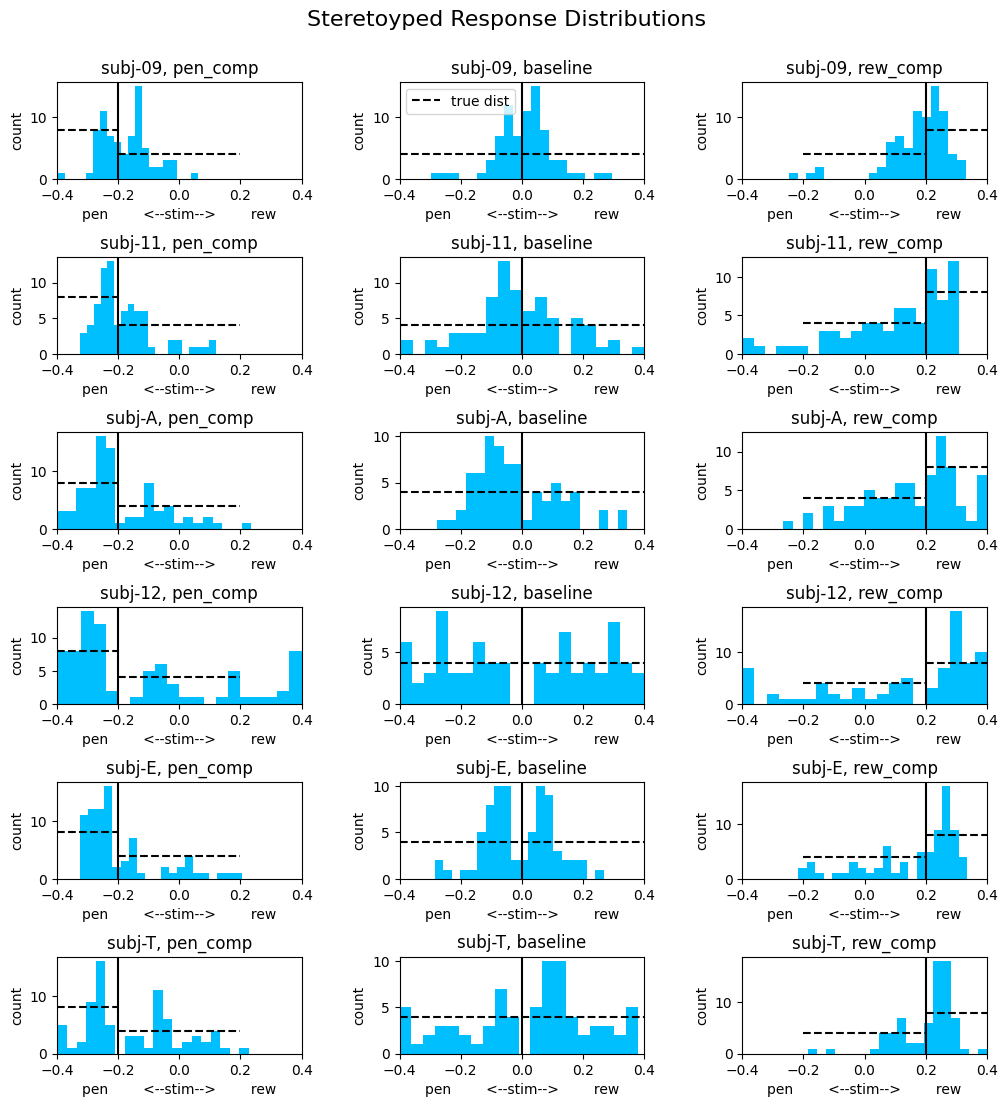

In [22]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# A. individual plots
fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 2*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        axs[ax].set(title=f'subj-{subj}, {cond}',
                    xlabel='pen        <--stim-->        rew', ylabel='count', xlim=(-.4, .4))
        axs[ax].hist(subj_cond_df['chosen_pos_aligned'], bins=20, color='deepskyblue')
        axs[ax].axvline(subj_cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
        
        # true dist line depends on cond
        if cond == 'baseline':
            axs[ax].axhline(4, color='black', linestyle='--', label='true dist')
        elif cond == 'pen_comp':
            axs[ax].hlines(8, -.4, -.2, color='black', linestyle='--', label='true dist')
            axs[ax].hlines(4, -.2, .2, color='black', linestyle='--')
        elif cond == 'rew_comp':
            axs[ax].hlines(4, -.2, .2, color='black', linestyle='--', label='true dist')
            axs[ax].hlines(8, .2, .4, color='black', linestyle='--')
        
        ax += 1

axs[1].legend()
plt.suptitle(f'Steretoyped Response Distributions', fontsize=16)
fig.subplots_adjust(wspace=.4, hspace=.8, top=.92)
plt.show()


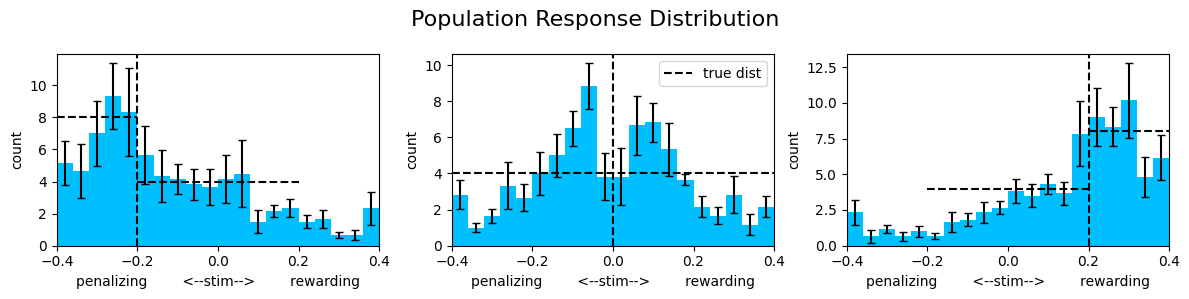

In [23]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# B. population
fig, axs = plt.subplots(1, 3, figsize=(4*len(conds), 3))
axs, ax = axs.flatten(), 0

for cond in conds:
    cond_df = df_analysis[df_analysis['condition'] == cond].copy()

    # compute a histogram of responses per subj
    resp_cts = []
    for subj, subj_df in cond_df.groupby('subj'):
        counts, _ = np.histogram(subj_df['chosen_pos_aligned'], bins=20)
        resp_cts.append(counts)
    resp_cts = np.array(resp_cts)

    mean_resp_cts = resp_cts.mean(axis=0)
    sen_resp_cts = resp_cts.std(axis=0) / np.sqrt(resp_cts.shape[0])

    # plot
    axs[ax].bar(np.linspace(-.38,.38,20), mean_resp_cts, width=.04,
                color='deepskyblue', yerr=sen_resp_cts, capsize=3)

    axs[ax].set(xlabel='penalizing        <--stim-->        rewarding',
                ylabel='count', xlim=(-.4, .4))

    # divider
    axs[ax].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='--')

    # true dist lines
    if cond == 'baseline':
        axs[ax].axhline(4, color='black', linestyle='--', label='true dist')
    elif cond == 'pen_comp':
        axs[ax].hlines(8, -.4, -.2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(4, -.2, .2, color='black', linestyle='--')
    elif cond == 'rew_comp':
        axs[ax].hlines(4, -.2, .2, color='black', linestyle='--', label='true dist')
        axs[ax].hlines(8, .2, .4, color='black', linestyle='--')
 
    ax += 1

axs[1].legend()
plt.suptitle(f'Population Response Distribution', fontsize=16)
plt.tight_layout()
plt.show()


## stim vs resp

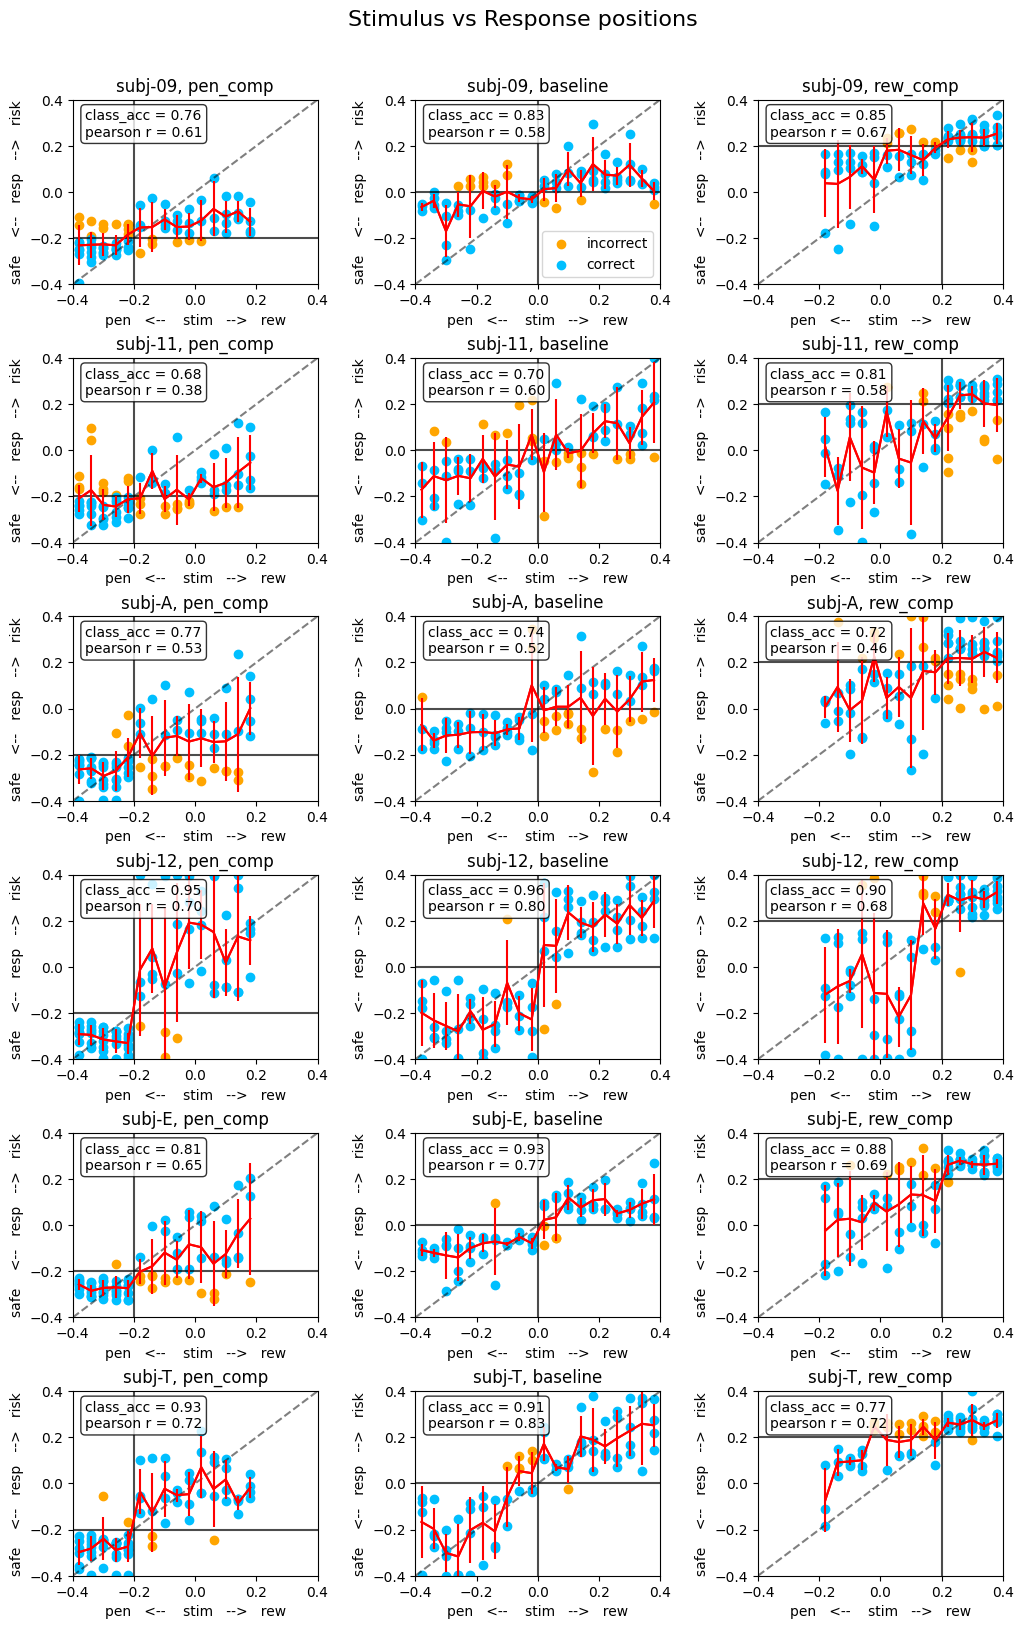

In [24]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# plot info
color_map = {False: 'orange', True: 'deepskyblue'}
label_map = {False: 'incorrect', True: 'correct'}

fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        # SETUP
        # diagonal for perfect accuracy
        axs[ax].plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)

        # calculate and plot performance
        pearson_r = subj_cond_df['stim_pos_aligned'].corr(subj_cond_df['chosen_pos_aligned'], method='pearson')
        accuracy = subj_cond_df['correct'].mean()
        axs[ax].text(0.05, 0.95, f'class_acc = {accuracy:.2f}\npearson r = {pearson_r:.2f}', 
                    transform=axs[ax].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
        # divider
        div_pos = subj_cond_df['div_pos_aligned'].iloc[0]
        axs[ax].axvline(div_pos, color='black', linestyle='-', alpha=0.7)
        axs[ax].axhline(div_pos, color='black', linestyle='-', alpha=0.7)
        
        # set
        axs[ax].set(xlabel='pen   <--    stim   -->   rew', 
                    ylabel='safe    <--   resp   -->   risk',
                    xlim=(-.4, .4), ylim=(-.4, .4), title=f'subj-{subj}, {cond}')
        
        # PLOT
        # points
        for acc, acc_df in subj_cond_df.groupby('correct'):        
            axs[ax].scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'],
                            color=color_map[acc], label=label_map[acc])
                
        # Calculate mean and SD of chosen position for each stimulus position
        mean_chosen_per_stim = subj_cond_df.groupby('stim_pos_aligned')['chosen_pos_aligned'].agg(['mean', 'std']).reset_index()
        mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_pos_aligned')
        
        # mean
        axs[ax].plot(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], color='red')
        
        # err bars
        axs[ax].errorbar(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], 
                        yerr=mean_chosen_per_stim['std'], color= 'red')

        ax += 1

axs[1].legend()
plt.suptitle('Stimulus vs Response positions', fontsize=16)
fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
plt.show()


ZIFest

In [25]:
plt.rcParams.update({
    "axes.titlesize": 20,   # subplot titles
    "axes.labelsize": 20,   # x/y labels
    "xtick.labelsize": 14,  # x ticks
    "ytick.labelsize": 14,  # y ticks
})

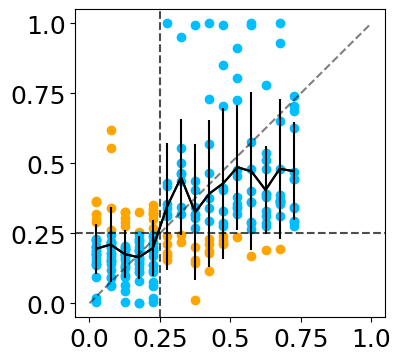

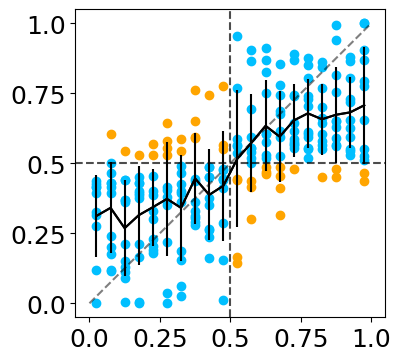

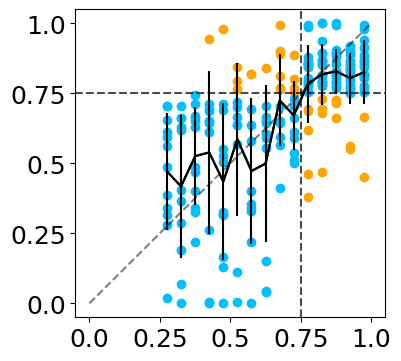

In [52]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')
patients = ['09', '11', '12']
df_analysis = df_analysis[df_analysis['subj'].isin(patients)].copy()

# plot info
color_map = {False: 'orange', True: 'deepskyblue'}
label_map = {False: 'incorrect', True: 'correct'}


for cond, title in zip(conds, ['gain-expanded', 'baseline', 'loss-expanded']):

    cond_df = df_analysis[df_analysis['condition'] == cond].copy()

    plt.figure(figsize=(4,4))
        
    # divider
    div_pos = cond_df['div_pos_aligned'].iloc[0]
    plt.axvline(div_pos, color='black', linestyle='--', alpha=0.7)
    plt.axhline(div_pos, color='black', linestyle='--', alpha=0.7, label='boundary')
    # diagonal
    plt.plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)

    # points
    for acc, acc_df in cond_df.groupby('correct'):        
        plt.scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'],
                        color=color_map[acc], label=label_map[acc])
            
    # Calculate mean and SD of chosen position for each stimulus position
    mean_chosen_per_stim = cond_df.groupby('stim_pos_aligned')['chosen_pos_aligned'].agg(['mean', 'std']).reset_index()
    mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_pos_aligned')
    
    # mean
    plt.plot(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], color='black')
    # err bars
    plt.errorbar(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], 
                    yerr=mean_chosen_per_stim['std'], color= 'black')

    # calculate and plot performance
    pearson_r = cond_df['stim_pos_aligned'].corr(cond_df['chosen_pos_aligned'], method='pearson')
    accuracy = cond_df['correct'].mean()

    # plt.title(f'class acc = {accuracy:.2f}')
    # plt.xlabel('context\nstim')
    # plt.ylabel('belief resp')
    ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)
    plt.xticks(ticks, labels)
    plt.yticks(ticks, labels)
    # if title=='baseline': plt.legend()
    plt.show()


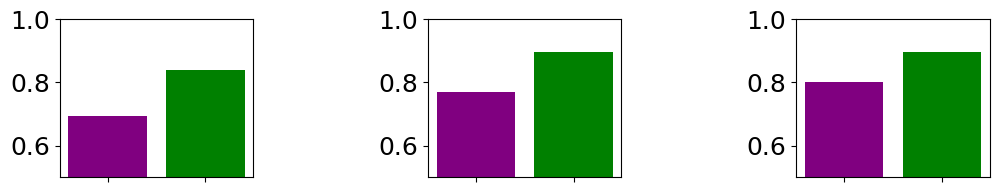

In [82]:
plt.rcParams.update({
    "axes.titlesize": 20,   # subplot titles
    "axes.labelsize": 20,   # x/y labels
    "xtick.labelsize": 18,  # x ticks
    "ytick.labelsize": 18,  # y ticks
})

subj_or_pop, df_analysis = get_df(df_clean, 'pop')
patients = ['09', '11', '12']

n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 2*n_rows))
axs, ax = axs.flatten(), 0

for subj in patients:

    if subj!='09': continue

    for cond, title in zip(conds, ['gain-expanded', 'baseline', 'loss-expanded']):
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        acc_by_contxt = subj_cond_df.groupby('class_true')['correct'].mean()

        axs[ax].bar(acc_by_contxt.index, acc_by_contxt.values, color=['purple', 'g'])
        axs[ax].set(ylim=(.5, 1), xticks=[0, 1], xticklabels=['', ''])
        if ax!=0: axs[ax].set(ylabel='')
        ax += 1

# subplot adjust
fig.subplots_adjust(wspace=.9, top=.9)
plt.show()


## zifest

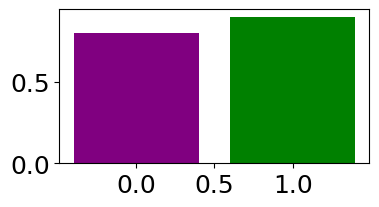

In [79]:
plt.rcParams.update({
    "axes.titlesize": 20,   # subplot titles
    "axes.labelsize": 20,   # x/y labels
    "xtick.labelsize": 18,  # x ticks
    "ytick.labelsize": 18,  # y ticks
})

plt.figure(figsize=(4,2))

subj_cond_df = df_analysis[(df_analysis['subj'] == '09') & (df_analysis['condition'] == 'rew_comp')].copy()
acc_by_contxt = subj_cond_df.groupby('class_true')['correct'].mean()
plt.bar(acc_by_contxt.index, acc_by_contxt.values, color=['purple', 'g'])
plt.show()


/home/nuttidalab/miniconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


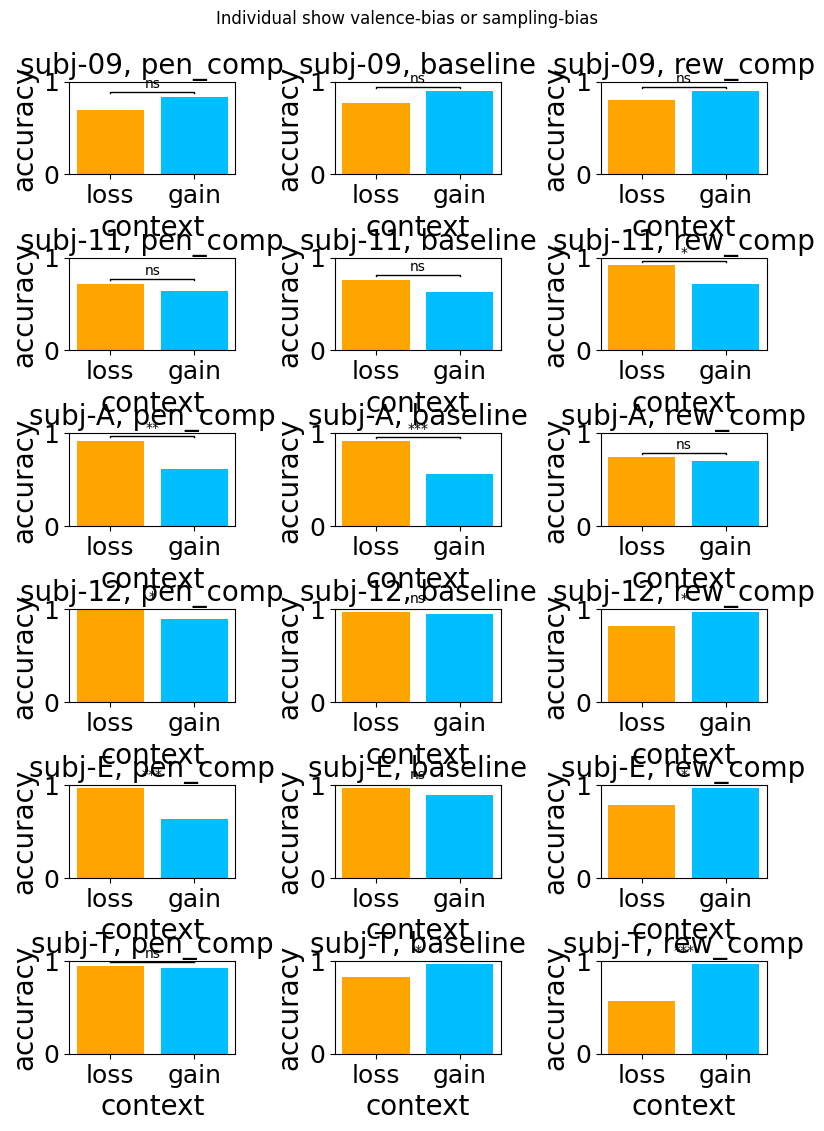

In [28]:
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

fig, axs = plt.subplots(len(subjs), len(conds), figsize=(3*len(conds), 2*len(subjs)))
axs, ax = axs.flatten(), 0

from scipy.stats import ttest_ind
import numpy as np

def p_to_stars(p):
    return 'ns' if p >= 0.05 else ('*' if p < 0.05 and p >= 0.01 else ('**' if p < 0.01 and p >= 0.001 else '***'))

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        acc_by_contxt = subj_cond_df.groupby('class_true')['correct'].mean()
        axs[ax].bar(acc_by_contxt.index, acc_by_contxt.values, color=['orange', 'deepskyblue'])
        axs[ax].set(title=f'subj-{subj}, {cond}', xlabel='context', ylim=(0, 1), ylabel='accuracy',
                    xticks=[0, 1], xticklabels=['loss', 'gain'])

        # --- significance test + annotation ---
        loss = subj_cond_df.loc[subj_cond_df['class_true'] == 0, 'correct'].astype(float).values
        gain = subj_cond_df.loc[subj_cond_df['class_true'] == 1, 'correct'].astype(float).values
        if len(loss) > 1 and len(gain) > 1:  # need at least 2 trials each for t-test to behave
            tstat, pval = ttest_ind(loss, gain, equal_var=False)  # Welch t-test on 0/1 accuracies
            y_bar = float(np.nanmax(acc_by_contxt.values)) + 0.04
            y_text = y_bar + 0.02
            axs[ax].plot([0, 0, 1, 1], [y_bar, y_bar+0.01, y_bar+0.01, y_bar], lw=1, c='k')
            axs[ax].text(0.5, y_text, p_to_stars(pval), ha='center', va='bottom', fontsize=10)
        else:
            axs[ax].text(0.5, 0.98, 'n<2', ha='center', va='top', transform=axs[ax].transAxes, fontsize=9)

        ax += 1

plt.suptitle('Individual show valence-bias or sampling-bias')
fig.subplots_adjust(wspace=.6, hspace=.9, top=.92)
plt.show()

In [29]:
# # choose what youre plotting
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')
# df_base = df_analysis[df_analysis['condition'] == 'baseline']

# for subj in ['12', '09', 'A']:
    
#     plt.figure(figsize=(4, 4))

#     subj_df = df_base[df_base['subj'] == subj].copy()

#     # calculate and plot performance
#     pearson_r = subj_df['stim_pos_aligned'].corr(subj_df['chosen_pos_aligned'], method='pearson')
#     accuracy = subj_df['correct'].mean()
#     plt.text(0.05, 0.95, f'class_acc = {accuracy:.2f}\npearson r = {pearson_r:.2f}', 
#              transform=plt.gca().transAxes, verticalalignment='top',
#              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#     # divider & diagonal
#     div_pos = subj_df['div_pos_aligned'].iloc[0]
#     plt.axvline(div_pos, color='black', linestyle='-', alpha=0.7)
#     plt.axhline(div_pos, color='black', linestyle='-', alpha=0.7)
#     plt.plot([-.4, .4], [-.4, .4], 'k--', alpha=0.5)

#     # reformat axes
#     ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)
#     plt.title(f'subj-{subj}')
#     plt.xlabel('pen    <--stim-->    rew')
#     plt.ylabel('resp')
#     plt.xticks(ticks, labels)
#     plt.yticks(ticks, labels)

#     # points
#     for acc, acc_df in subj_df.groupby('correct'):        
#         plt.scatter(acc_df['stim_pos_aligned'], acc_df['chosen_pos_aligned'],
#                     color=color_map[acc], label=label_map[acc])
#     # plt.scatter(subj_df['stim_pos_aligned'], subj_df['chosen_pos_aligned'], c=subj_df['correct'], cmap='bwr_r', alpha=0.7, label=subj_df['correct'])

#     # mean and SD of chosen position for each stimulus position
#     mean_chosen_per_stim = subj_df.groupby('stim_pos_aligned')['chosen_pos_aligned'].agg(['mean', 'std']).reset_index()
#     mean_chosen_per_stim = mean_chosen_per_stim.sort_values('stim_pos_aligned')
#     plt.plot(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'], color='k')
#     plt.errorbar(mean_chosen_per_stim['stim_pos_aligned'], mean_chosen_per_stim['mean'],
#                  yerr=mean_chosen_per_stim['std'], color='k')

#     plt.legend()
#     plt.savefig(f'../../data/eps_figs/subj-{subj}_baseline_scatter.eps', format='eps', dpi=300, bbox_inches='tight')
#     plt.show()


## absolute error by position

In [30]:
# subj_or_pop, df_analysis = get_df(df_clean, 'pop')

# fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

#         subj_cond_df['|err|'] = np.abs(subj_cond_df['stim_pos_aligned'] - subj_cond_df['chosen_pos_aligned'])
#         err_by_stim = subj_cond_df.groupby('stim_pos_aligned')['|err|'].mean()

#         axs[ax].plot(err_by_stim.index, err_by_stim.values, marker='o')
#         axs[ax].axvline(subj_cond_df['div_pos_aligned'].iloc[0], color='k', linestyle='--', alpha=0.6)
#         axs[ax].set(title=f'subj-{subj}, {cond}', xlabel='stim pos', ylabel='|err|')

#         ax += 1

# plt.suptitle(f'Abs. error per Stim Position', fontsize=16)
# fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
# plt.show()


## within-block ranked data
points are ranked per complete sweep of stims

In [31]:
# # # rank within a block for each subj/cond
# # grp = ['subj', 'condition', 'blockN']
# # df_analysis['stim_ranks'] = df_analysis.groupby(grp)['stim_pos_aligned'].rank()
# # df_analysis['resp_ranks'] = df_analysis.groupby(grp)['chosen_pos_aligned'].rank()
# # max_rank = df_analysis['stim_ranks'].max()

# fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()
        
#         axs[ax].set(xlabel='stim ranks', ylabel='resp ranks', title=f'subj-{subj}, {cond}')

#         # hline
#         axs[ax].axhline(max_rank/2, color='k', linestyle='--', alpha=0.5)
#         axs[ax].axvline(max_rank/2, color='k', linestyle='--', alpha=0.5)

#         # spearman
#         spearman_r = subj_cond_df['stim_pos_aligned'].corr(subj_cond_df['chosen_pos_aligned'], method='spearman')
#         axs[ax].text(0.05, 0.95, f'spearman = {spearman_r:.2f}', transform=axs[ax].transAxes, verticalalignment='top',
#                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

#         # mean & sd of resp ranks
#         mean_ranks = subj_cond_df.groupby('stim_ranks')['resp_ranks'].agg(['mean', 'std']).reset_index()

#         # plot
#         for acc, acc_df in subj_cond_df.groupby('correct'):        
#             axs[ax].scatter(acc_df['stim_ranks'], acc_df['resp_ranks'],
#                             color=color_map[acc], label=label_map[acc])
#         # diagonal
#         axs[ax].plot([1, max_rank], [1, max_rank], 'k--', alpha=0.5)
#         # mean & sd
#         axs[ax].plot(mean_ranks['stim_ranks'], mean_ranks['mean'], color='red')
#         axs[ax].errorbar(mean_ranks['stim_ranks'], mean_ranks['mean'],
#                         yerr=mean_ranks['std'], color='red')
            
#         ax += 1

# axs[1].legend(loc='lower right')
# plt.suptitle(f'stim vs response ranks (subj-{subj_or_pop})', fontsize=16)
# fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
# plt.show()


## absolute error by position rank

In [32]:
# # rank within a block for each subj/cond
# grp = ['subj', 'condition', 'blockN']
# df_analysis['stim_ranks'] = df_analysis.groupby(grp)['stim_pos_aligned'].rank()
# df_analysis['resp_ranks'] = df_analysis.groupby(grp)['chosen_pos_aligned'].rank()

# fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
# axs, ax = axs.flatten(), 0

# for subj in subjs:
#     for cond in conds:
#         subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

#         subj_cond_df['|rank-err|'] = np.abs(subj_cond_df['stim_ranks'] - subj_cond_df['resp_ranks'])
#         err_by_stim = subj_cond_df.groupby('stim_ranks')['|rank-err|'].mean()

#         axs[ax].plot(err_by_stim.index, err_by_stim.values, marker='o')
#         axs[ax].axvline(20, color='k', linestyle='--', alpha=0.6)
#         axs[ax].set(title=f'subj-{subj}, {cond}', xlabel='stim rank', xlim=(0, 40), ylabel='|rank-err|', ylim=(0, 20))

#         ax += 1

# plt.suptitle(f'Abs. rank error per Stim Position', fontsize=16)
# fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
# plt.show()


## psychometric curves

functions

In [33]:
from scipy.optimize import curve_fit
from scipy.stats import norm

def wilson_errs(k, n, alpha=0.05):
    z = norm.ppf(1 - alpha/2)
    p = k / n
    denom  = 1 + z**2/n
    center = (p + z**2/(2*n)) / denom
    half   = z*np.sqrt(p*(1-p)/n + z**2/(4*n**2)) / denom
    lo, hi = center - half, center + half           # bounds
    low_err  = max(0.0, p - lo)                     # distance from p
    high_err = max(0.0, hi - p)
    return low_err, high_err

def logistic(x, threshold, slope):
    return 1 / (1 + np.exp(-(x - threshold) / slope))

def get_subj_psychometric(subj, unique_positions, df_cond):
    
    # select subj and condition
    subj_cond_df = df_cond[df_cond['subj'] == subj]
    subjs_props, subjs_sderrs = [], []

    # calculate proportion right and sd errs per position
    for pos in unique_positions:

        # all trials with this stim_pos
        stim_pos_trials = subj_cond_df[subj_cond_df['stim_pos_aligned'] == pos]

        # proportion of class_pred == 1 (reward chosen)
        prop = stim_pos_trials['class_pred'].mean()
        # stderr = stats.sem(stim_pos_trials['class_pred'])
        stderr = np.sqrt(prop * (1 - prop) / len(stim_pos_trials))

        subjs_props.append(prop)
        subjs_sderrs.append(stderr)

    return np.array(subjs_props), np.array(subjs_sderrs)


ZIFest

In [34]:
positions = np.unique(df_base['stim_pos_aligned'])
ticks, labels = np.linspace(-.4, .4, 5), np.linspace(0, 1, 5)

plt.figure(figsize=(4, 4))

for subj in subjs:
    props, sderrs = get_subj_psychometric(subj, positions, df_base)

    # fit logistic curve
    param_init = [0, 1]
    [bias, slope], _ = curve_fit(logistic, positions, props, p0=param_init)
    fitted_curve = logistic(positions, *[bias, slope])
    
    # plt.errorbar(positions, props, yerr=1.96*sderrs, fmt='o', ms=3, alpha=0.7)
    plt.plot(positions, fitted_curve, alpha=0.5)
    
    plt.xticks(ticks, labels) # reformat

plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title(f'Psychometric curves across subjects')
plt.xlabel('pen    <--stim-->    rew')
plt.ylabel('P (right)')
plt.show()

NameError: name 'df_base' is not defined

plot

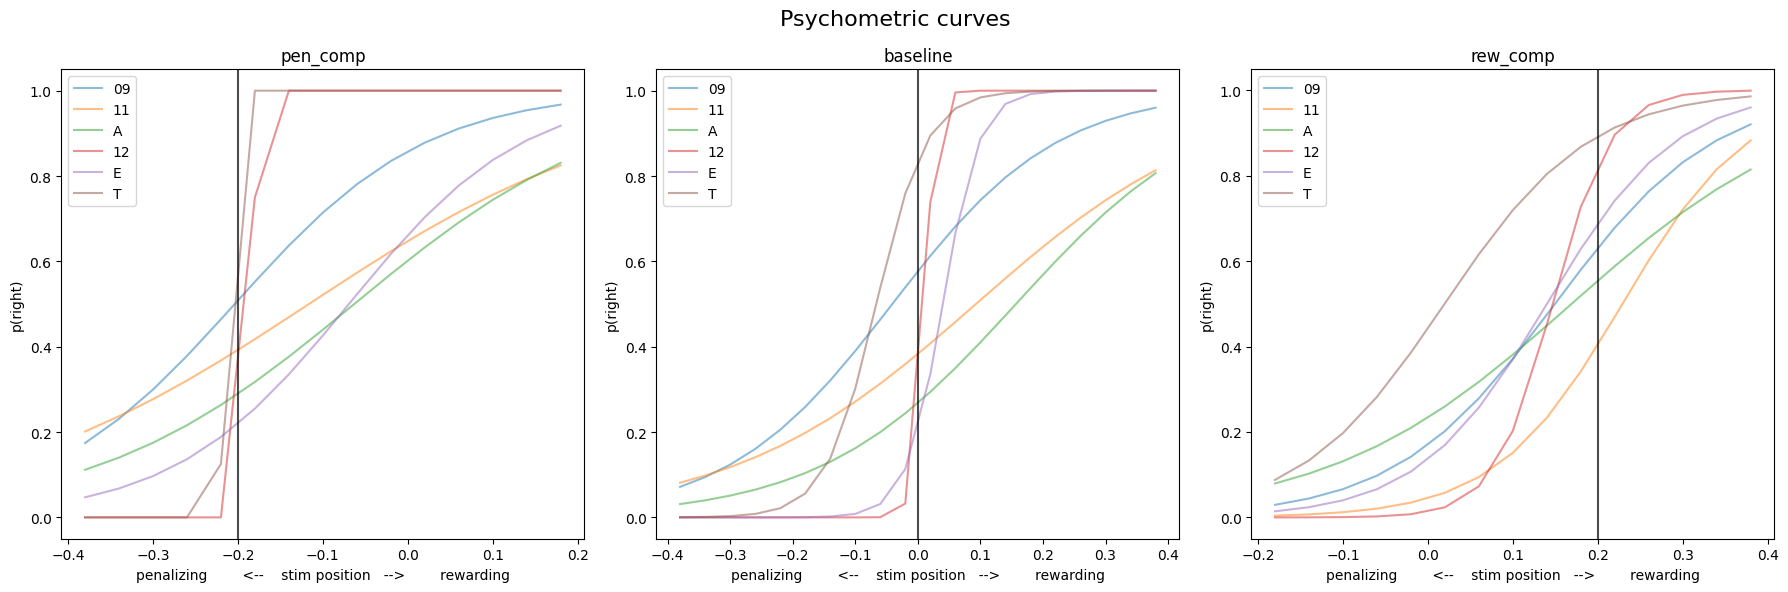

In [ ]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs, ax = axs.flatten(), 0

for cond in conds:
    cond_df = df_analysis[df_analysis['condition'] == cond].copy()

    # positions used in this condition
    cond_positions = np.sort(cond_df['stim_pos_aligned'].unique())
    cond_div = cond_df['div_pos_aligned'].iloc[0]

    # get psychometric data for each subject
    for subj in subjs:
        props, sderrs = get_subj_psychometric(subj, cond_positions, cond_df)
        
        # fit logistic curve
        param_init = [cond_div, 1]
        [bias, slope], _ = curve_fit(logistic, cond_positions, props, p0=param_init)
        fitted_curve = logistic(cond_positions, *[bias, slope])
        
        # axs[ax].errorbar(cond_positions, props, yerr=sderrs, fmt='o', label=f'subj-{subj}')
        axs[ax].plot(cond_positions, fitted_curve, label=f'{subj}', alpha=0.5)

    axs[ax].axvline(cond_div, color='black', linestyle='-', alpha=0.7)
    axs[ax].set(title=cond, xlabel='penalizing        <--    stim position   -->        rewarding', ylabel='p(right)')
    axs[ax].legend()
    ax += 1

plt.suptitle(f'Psychometric curves', fontsize=16)
plt.tight_layout()
plt.show()

## accuracy & RT by position

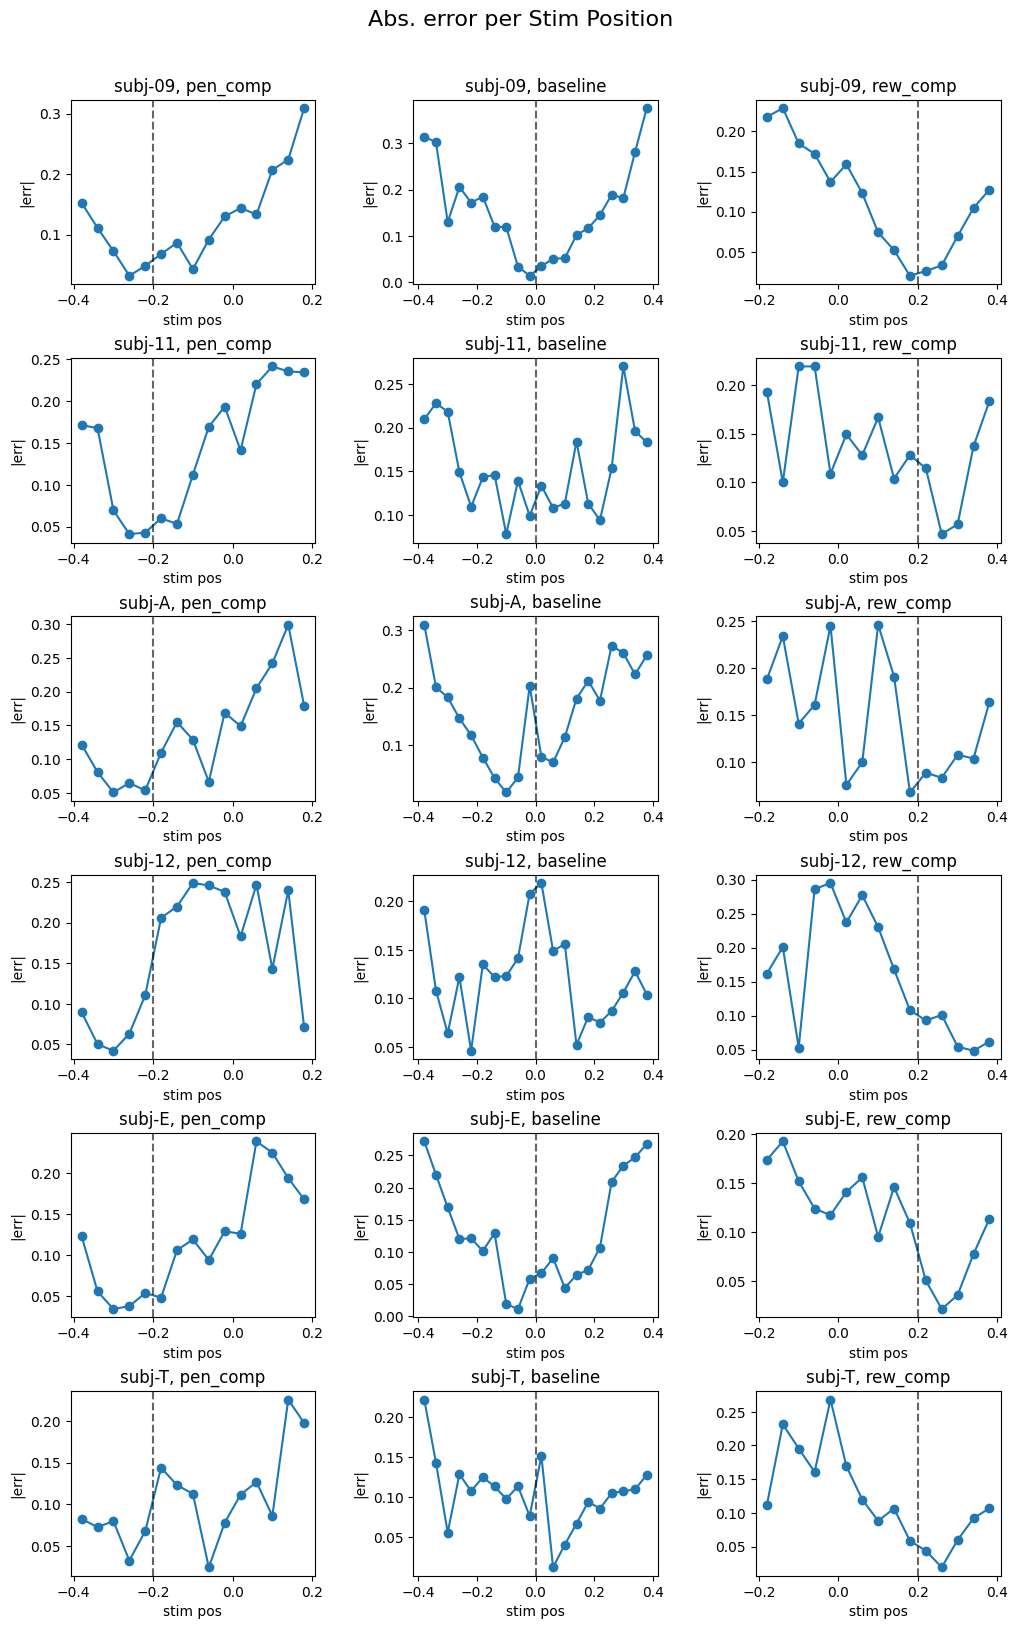

In [ ]:
fig, axs = plt.subplots(len(subjs), 3, figsize=(4*len(conds), 3*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in conds:
        subj_cond_df = df_analysis[(df_analysis['subj'] == subj) & (df_analysis['condition'] == cond)].copy()

        subj_cond_df['|err|'] = np.abs(subj_cond_df['stim_pos_aligned'] - subj_cond_df['chosen_pos_aligned'])
        err_by_stim = subj_cond_df.groupby('stim_pos_aligned')['|err|'].mean()

        axs[ax].plot(err_by_stim.index, err_by_stim.values, marker='o')
        axs[ax].axvline(subj_cond_df['div_pos_aligned'].iloc[0], color='k', linestyle='--', alpha=0.6)
        axs[ax].set(title=f'subj-{subj}, {cond}', xlabel='stim pos', ylabel='|err|')

        ax += 1

plt.suptitle(f'Abs. error per Stim Position', fontsize=16)
fig.subplots_adjust(wspace=.4, hspace=.4, top=.93)
plt.show()


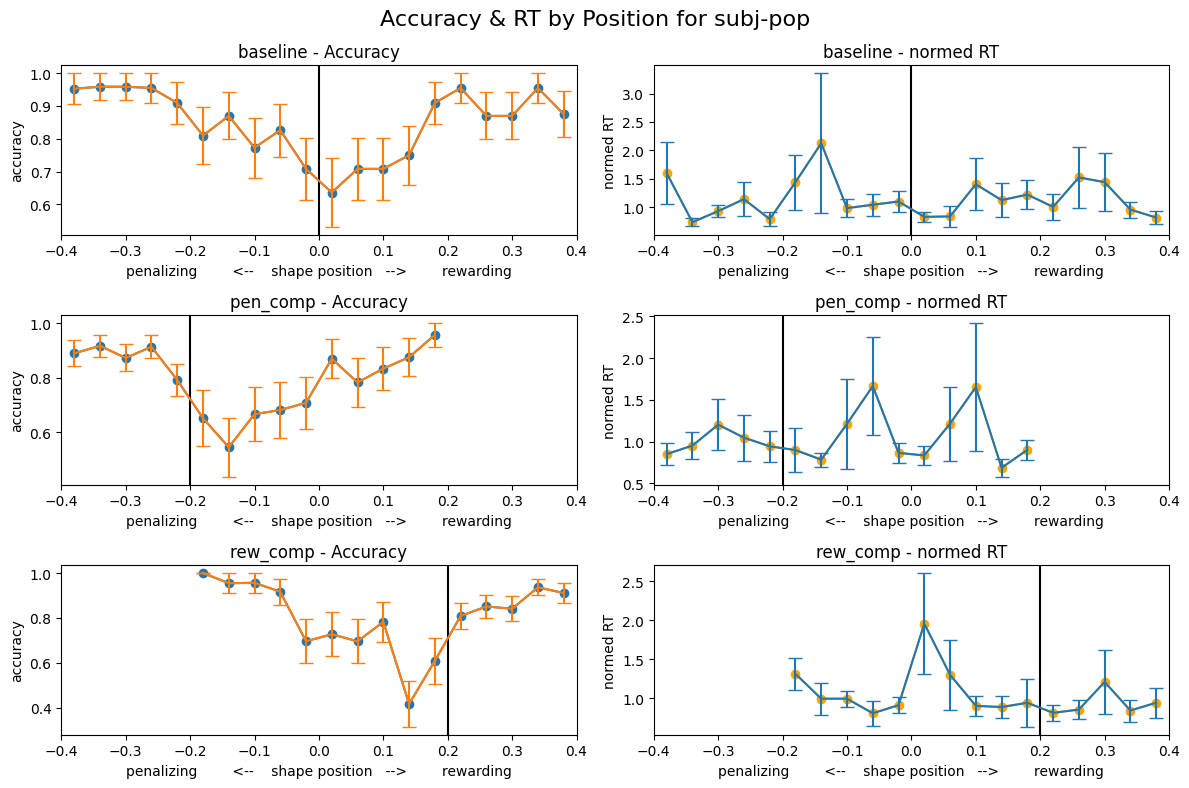

In [ ]:
# choose what youre plotting
subj_or_pop, df_analysis = get_df(df_clean, 'pop')

fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i, (cond, cond_df) in enumerate(df_analysis.groupby('condition')):
    mean_metrics = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].mean().reset_index()
    sem_metrics  = cond_df.groupby('stim_pos_aligned')[['correct', 'normed_RT']].sem().reset_index()
    
    # Accuracy plot (col 1)
    axs[i, 0].set(xlabel='penalizing        <--    shape position   -->        rewarding', 
                  ylabel='accuracy', xlim=(-.4, .4), title=f'{cond} - Accuracy')
    axs[i, 0].plot(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], marker='o')
    axs[i, 0].errorbar(mean_metrics['stim_pos_aligned'], mean_metrics['correct'], 
                       yerr=sem_metrics['correct'].values, capsize=5)
    axs[i, 0].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')
    
    # RT plot (col 2)
    axs[i, 1].set(xlabel='penalizing        <--    shape position   -->        rewarding', 
                  ylabel='normed RT', xlim=(-.4, .4), title=f'{cond} - normed RT')
    axs[i, 1].plot(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], marker='o', color='orange')
    axs[i, 1].errorbar(mean_metrics['stim_pos_aligned'], mean_metrics['normed_RT'], 
                       yerr=sem_metrics['normed_RT'].values, capsize=5)
    axs[i, 1].axvline(cond_df['div_pos_aligned'].iloc[0], color='black', linestyle='-')

plt.suptitle(f'Accuracy & RT by Position for subj-{subj_or_pop}', fontsize=16)
plt.tight_layout()
plt.show()


# 6. analyses by valence & compression

condition
pen_comp    466
rew_comp    460
baseline    456
Name: count, dtype: int64
correct
1.0    1145
0.0     237
Name: count, dtype: int64
outcome
 1.0    580
 3.0    565
-1.0    127
-3.0    110
Name: count, dtype: int64


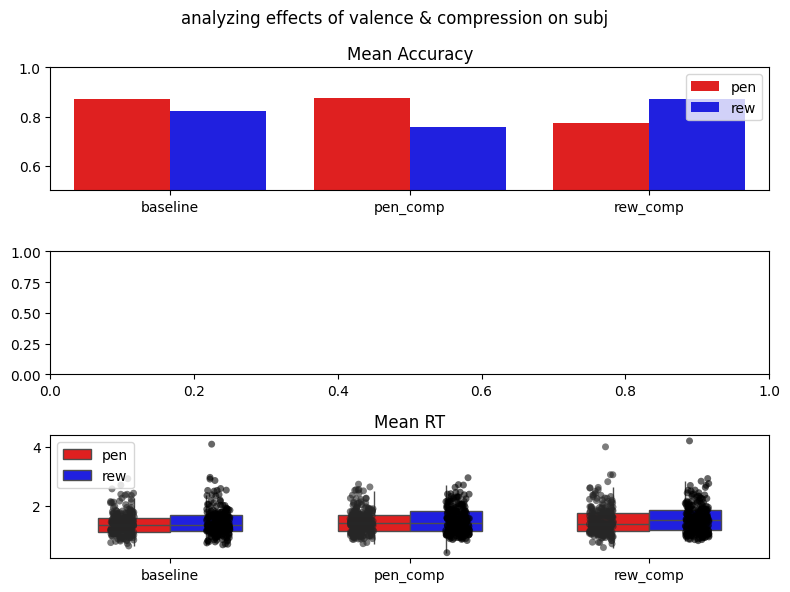

In [ ]:
# df_plot = df_hard.copy()
df_plot = df_analysis.copy()

df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['condition'].value_counts())
print(df_plot['correct'].value_counts())
print(df_plot['outcome'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence & compression on subj')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence', hue_order=hue_order, palette = palette, ax=ax, errorbar=None)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()

# 2.
# ax = axes[1]
# sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order,
#             palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
# sns.stripplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order, 
#               dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('Mean Absolute Error')
# ax.legend()

# 3.
ax = axes[2]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## analyses by valence space

percept_space
flat          347
very_flat     346
very_curvy    345
curvy         344
Name: count, dtype: int64


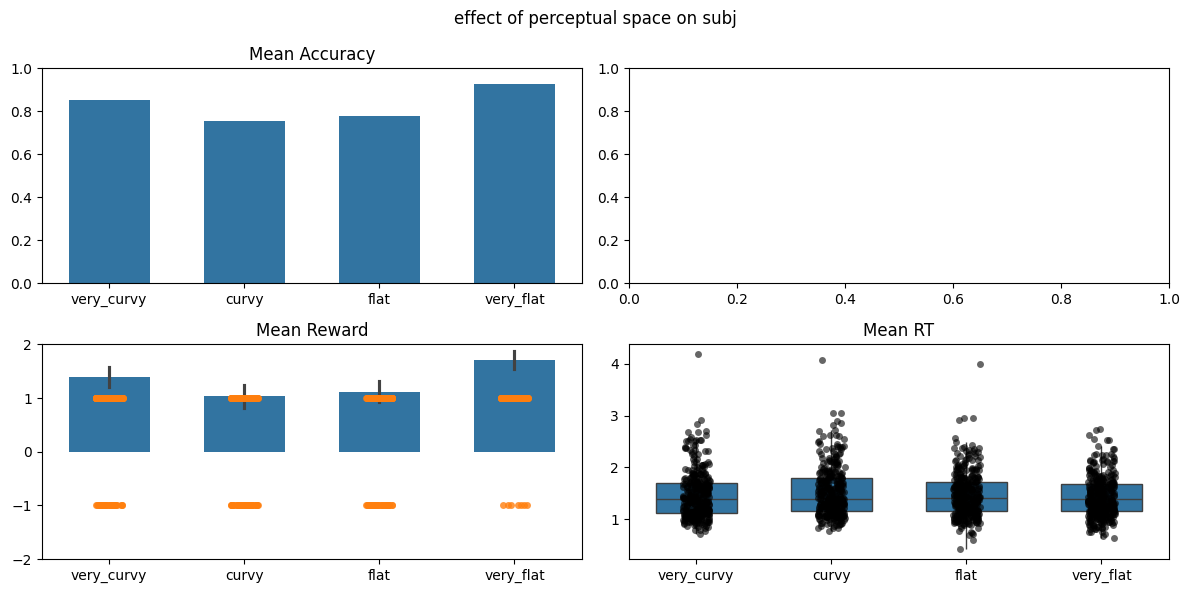

In [ ]:
df_plot = df_analysis.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels, default= 'undefined')

# arnav's percept space will be flipped
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effect of perceptual space on subj')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax, errorbar=None, order=percept_labels)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')

# 2. MAE
# ax = axes[1]
# sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
# sns.stripplot(data=df_plot, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, order=percept_labels, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_ylim(0, .6)
# ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
# ax.set_title('Mean Absolute Error (questionable norming)')

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, order=percept_labels, ax=ax)
sns.stripplot(data=df_plot, x='percept_space', y='outcome', dodge=True, alpha=0.8, jitter=True, order=percept_labels, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, order=percept_labels, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')

plt.tight_layout()
plt.show()



## plot class - class_hat

In [ ]:
# Step 1: Get mean accuracy per subject (across all conditions and valences)
subj_acc = df_subjs.groupby('subj')['correct'].mean().reset_index()

# Step 2: Compute SD across those subject-level accuracies
overall_sd = subj_acc['correct'].std()

print(f"SD across subjects: {overall_sd}")


SD across subjects: 0.08769488878217772


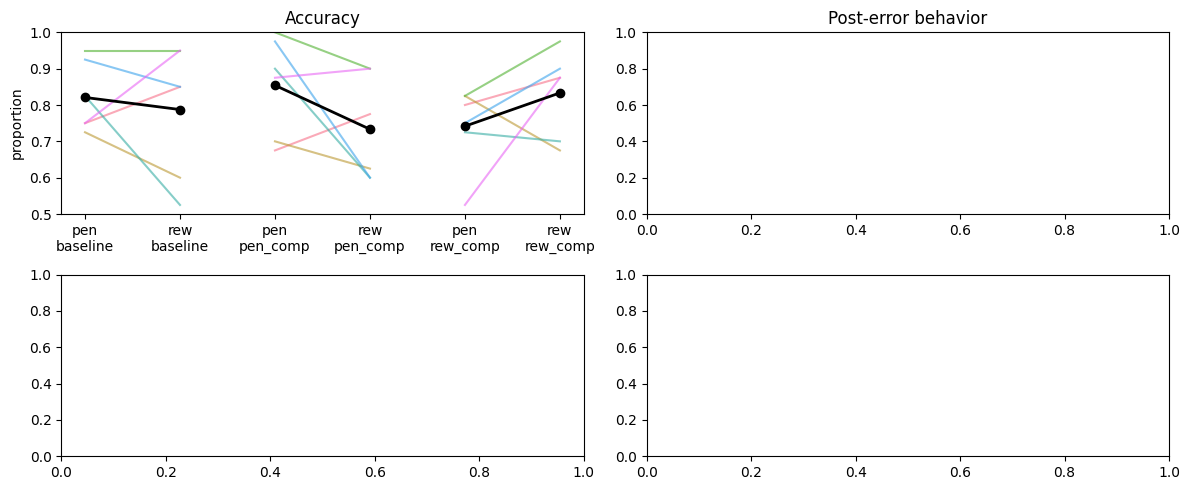

In [ ]:
# compute subject-level accuracy by valence & condition
subj_acc_df = df_subjs.groupby(['subj','condition','valence'])['correct'].mean().reset_index()

subj_acc_df['x_label'] = subj_acc_df['valence'].astype(str) + '\n' + subj_acc_df['condition'].astype(str)

# assign colors to subjects
subj_palette = dict(zip(subj_acc_df['subj'].unique(),
                        sns.color_palette('husl', n_colors=subj_acc_df['subj'].nunique())))

# compute population mean by condition & valence
pop_acc_df = subj_acc_df.groupby(['condition','valence'])['correct'].mean().reset_index()
pop_acc_df['x_label'] = pop_acc_df['valence'].astype(str) + '\n' + pop_acc_df['condition'].astype(str)

fig, axs = plt.subplots(2, 2, figsize=(12, 5))
axs, ax = axs.flatten(), 0

axs[ax].set_title('Accuracy')
# plot subjs
for subj, sub_df in subj_acc_df.groupby('subj'):
    for cond, cond_df in sub_df.groupby('condition'):
        axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                     color=subj_palette[subj], alpha=0.6)

# plot population
for cond, cond_df in pop_acc_df.groupby('condition'):
    axs[ax].plot(cond_df['x_label'], cond_df['correct'].values,
                 color='black', marker='o', linewidth=2)

axs[ax].set(ylabel='proportion', ylim=(.5, 1))
ax += 1

# post error behavior
axs[ax].set_title('Post-error behavior')
df_post_err = df_subjs[df_subjs['correct'].shift(-1) == False]

plt.tight_layout()
plt.show()


## rewards

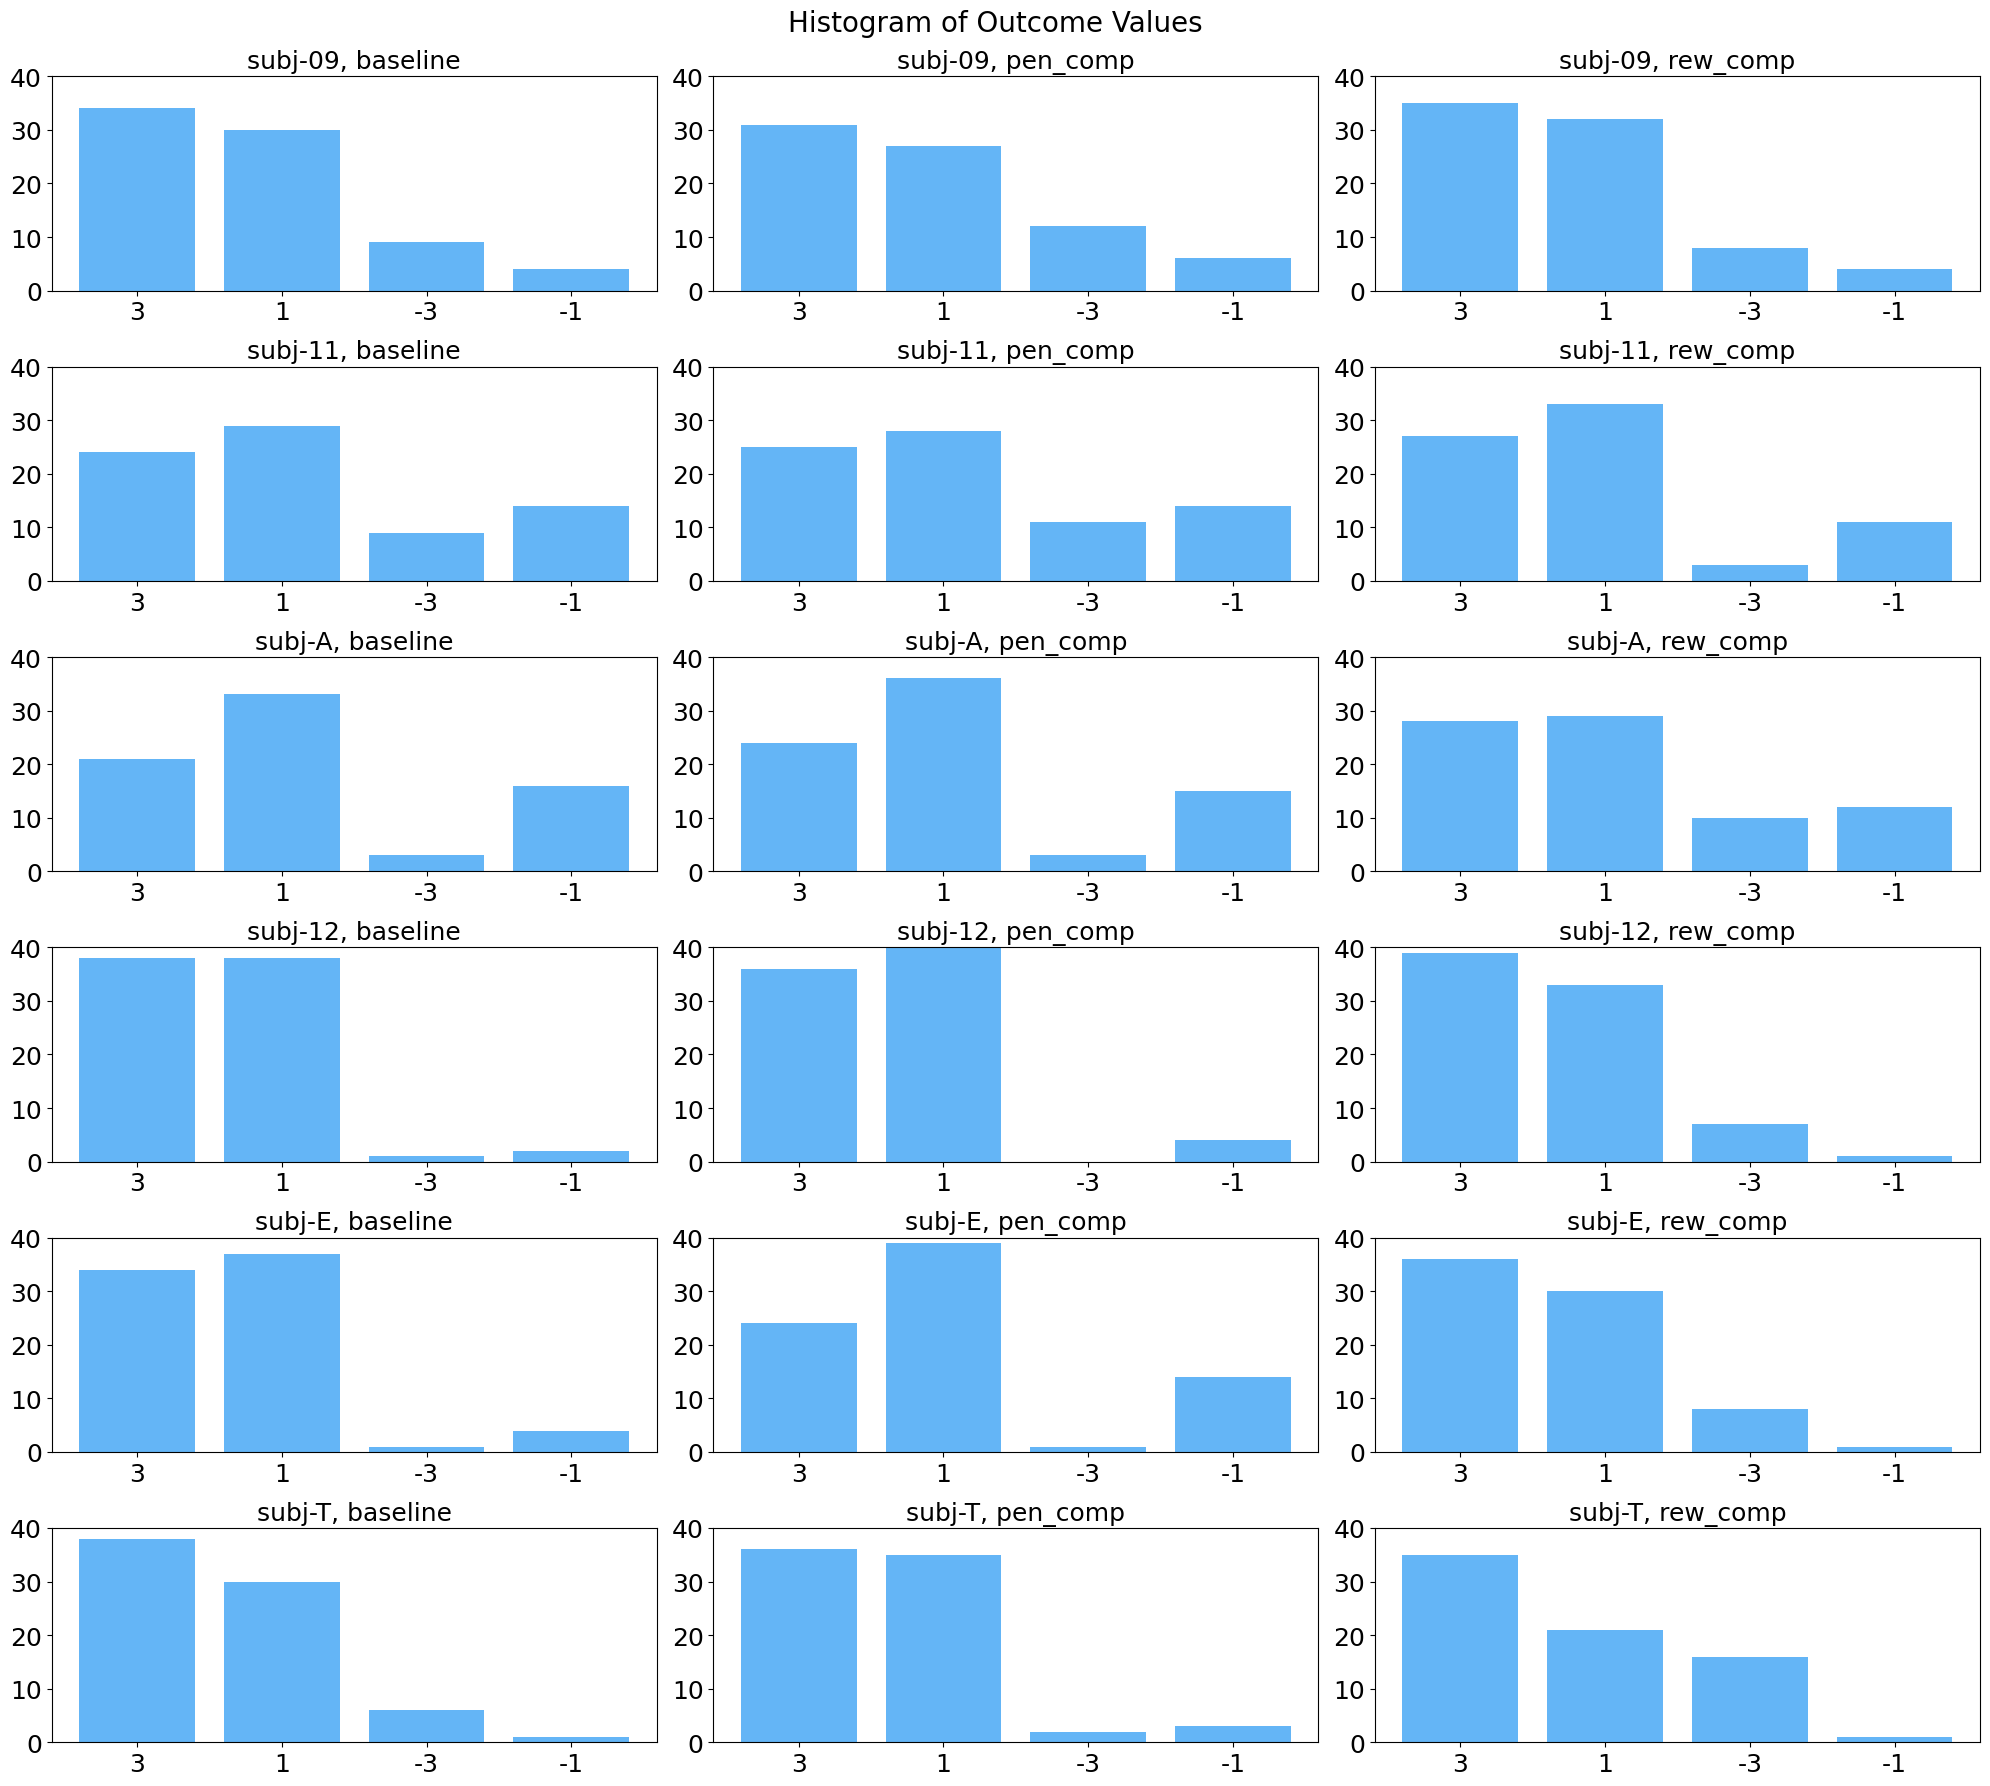

In [ ]:
# filter + safe copy
df_attempted = df_analysis.loc[df_analysis['outcome'].isin([1, -1, 3, -3])].copy()

val_order = [3, 1, -3, -1]                  # desired order
label   = [str(v) for v in val_order]         # or ["+3","+1","−3","−1"]

fig, axs = plt.subplots(len(subjs), 3, figsize=(20, 3*len(subjs)))
axs, ax = axs.flatten(), 0

for subj in subjs:
    for cond in df_attempted['condition'].unique():
        
        subj_cond_df = df_attempted[(df_attempted['subj'] == subj) &
                          (df_attempted['condition'] == cond)]

        # counts in desired order (fill zeros)
        counts = subj_cond_df['outcome'].value_counts().reindex(val_order, fill_value=0)

        # plot using fixed positions
        axs[ax].bar(range(4), counts.values, color='#64B5F6')

        axs[ax].set_ylim(0, 40)
        axs[ax].set_xticks(range(4))
        axs[ax].set_xticklabels(label, fontsize=18)
        axs[ax].tick_params(axis='y', labelsize=18)
        axs[ax].set_title(f'subj-{subj}, {cond}', fontsize=18)
        ax += 1

plt.suptitle('Histogram of Outcome Values', fontsize=20, y=.99)
plt.tight_layout()
plt.show()
